# El Fin (Final Exam) for AMPTH-2017/APMA E-207

**Harvard University**<br>
**Fall 2018**<br>
**Instructors: Rahul Dave**<br>
**Due Date:** Monday, December 17th, 2018 at 11:59pm

**Instructions:**

- Upload your final answers in the form of a Jupyter notebook containing all work to Canvas.

- Structure your notebook and your work to maximize readability.

### Collaborators

** Place the name of everyone who's submitting this assignment here**

In [1]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import seaborn.apionly as sns
import pandas as pd

import pymc3 as pm
from theano import shared
import theano
import theano.tensor as T

import torch # package for building functions with learnable parameters
import torch.nn as nn # prebuilt functions specific to neural networks
from torch.autograd import Variable # storing data while learning

%matplotlib inline

/Users/gwungwun/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Q1: GLMs with correlation

### The dataset: A Bangladesh Contraception use census

This problem is based on one-two (12H1 and continuations ) from your textbook. The data is in the file `bangladesh.csv`. These data are from the 1988 Bangladesh Fertility Survey. Each row is one of 1934 women. There are six variables:

- (1) `district`: ID number of administrative district each woman resided in
- (2) `use.contraception`: An indicator (0/1) of whether the woman was using contraception
- (3) `urban`: An indicator (0/1) of whether the woman lived in a city, as opposed to living in a rural area
- (4) `woman`: a number indexing a single woman in this survey
- (5) `living.chidren`: the number of children living with a woman
- (6) `age.centered`: a continuous variable representing the age of the woman with the sample mean subtracted

We need to make sure that the cluster variable, district, is a contiguous set of integers, so that we can use the index to differentiate the districts easily while sampling ((look at the Chimpanzee models we did in lab to understand the indexing). So create a new contiguous integer index to represent the districts. Give it a new column in the dataframe, such as `district.id`.

You will be investigating the dependence of contraception use on the district in which the survey was done. Specifically, we will want to regularize estimates from those districts where very few women were surveyed. We will further want to investigate whether the areas of residence (urban or rural) within a district impacts a woman's use of contraception.

Feel free to indulge in any exploratory visualization which helps you understand the dataset better.

In [2]:
bangladesh = pd.read_csv('bangladesh.csv', sep = ';')
bangladesh.head()

woman  district  use.contraception  living.children  age.centered  urban
0      1         1                  0                4       18.4400      1
1      2         1                  0                1       -5.5599      1
2      3         1                  0                3        1.4400      1
3      4         1                  0                4        8.4400      1
4      5         1                  0                1      -13.5590      1

In [5]:
bangladesh['district_id'] = bangladesh.district.apply(lambda x: x - 2 if x >54 else x - 1)

bangladesh.head()

woman  district  use.contraception  living.children  age.centered  urban  \
0      1         1                  0                4       18.4400      1   
1      2         1                  0                1       -5.5599      1   
2      3         1                  0                3        1.4400      1   
3      4         1                  0                4        8.4400      1   
4      5         1                  0                1      -13.5590      1   

   district_id  
0            0  
1            0  
2            0  
3            0  
4            0

## Part A

We will use `use.contraception` as a Bernoulli response variable. 

When we say "fit" below, we mean, specify the model, plot its graph, sample from it, do some tests, and forest-plot and summarize the posteriors, at the very least.

**A1** Fit a traditional "fixed-effects" model which sets up district-specific intercepts, each with its own Normal(0, 10) prior. That is, the intercept is modeled something like 

```python
alpha_district = pm.Normal('alpha_district', 0, 10, shape=num_districts)
p=pm.math.invlogit(alpha_district[df.district_id])
```

Why should there not be any overall intercept in this model? 

**A2** Fit a multi-level "varying-effects" model with an overall intercept `alpha`, and district-specific intercepts `alpha_district`. Assume that the overall intercept has a Normal(0, 10) prior, while the district specific intercepts are all drawn from the **same** normal distribution with mean 0 and standard deviation $\sigma$. Let $\sigma$ be drawn from HalfCauchy(2). The setup of this model is similar to the per-chimanzee models in the prosocial chimanzee labs.

**A3** What does a posterior-predictive sample in this model look like? What is the difference between district specific posterior predictives and woman specific posterior predictives. In other words, how might you model the posterior predictive for a new woman being from a particular district vs that os a new woman in the entire sample? This is a word answer; no programming required.

**A4** Plot the predicted proportions of women in each district using contraception against the id of the district, in both models. How do these models disagree? Look at the extreme values of predicted contraceptive use in the fixed effects model. How is the disagreement in these cases?

**A5** Plot the absolute value of the difference in probability of contraceptive use against the number of women sampled in each district. What do you see?

In [139]:
## A1 ## reducdant overall intercept
num_districts = bangladesh.district.nunique()

with pm.Model() as districtonly_model:
    alpha_district = pm.Normal('alpha_district', 0, 10, shape=num_districts)
    p=pm.math.invlogit(alpha_district[bangladesh.district_id])
    o = pm.Bernoulli("contraception", p=p, observed=bangladesh['use.contraception'])

In [143]:
with districtonly_model:
    trace_A1 = pm.sample(5000, tune=2000, step=pm.NUTS())

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha_district]
Sampling 2 chains: 100%|██████████| 14000/14000 [01:22<00:00, 170.47draws/s]


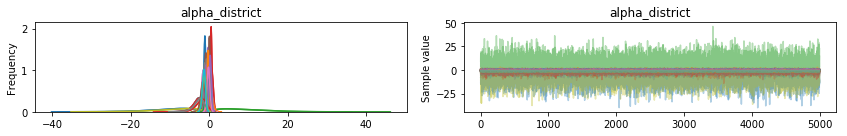

In [144]:
pm.traceplot(trace_A1);

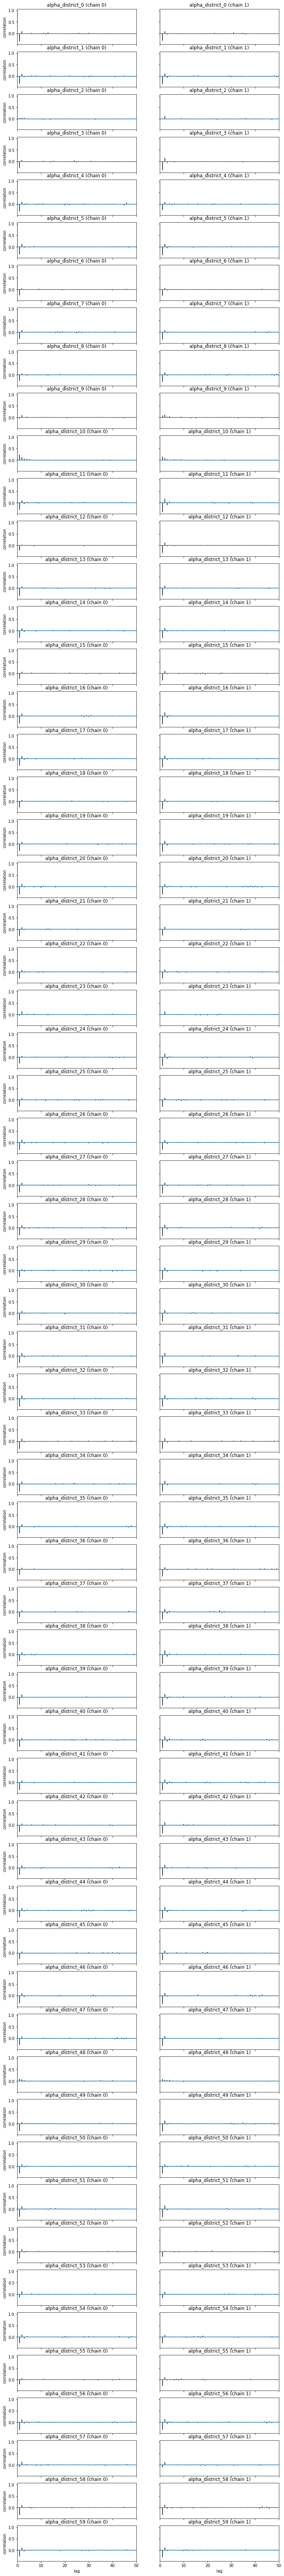

In [145]:
pm.autocorrplot(trace_A1, max_lag=50);

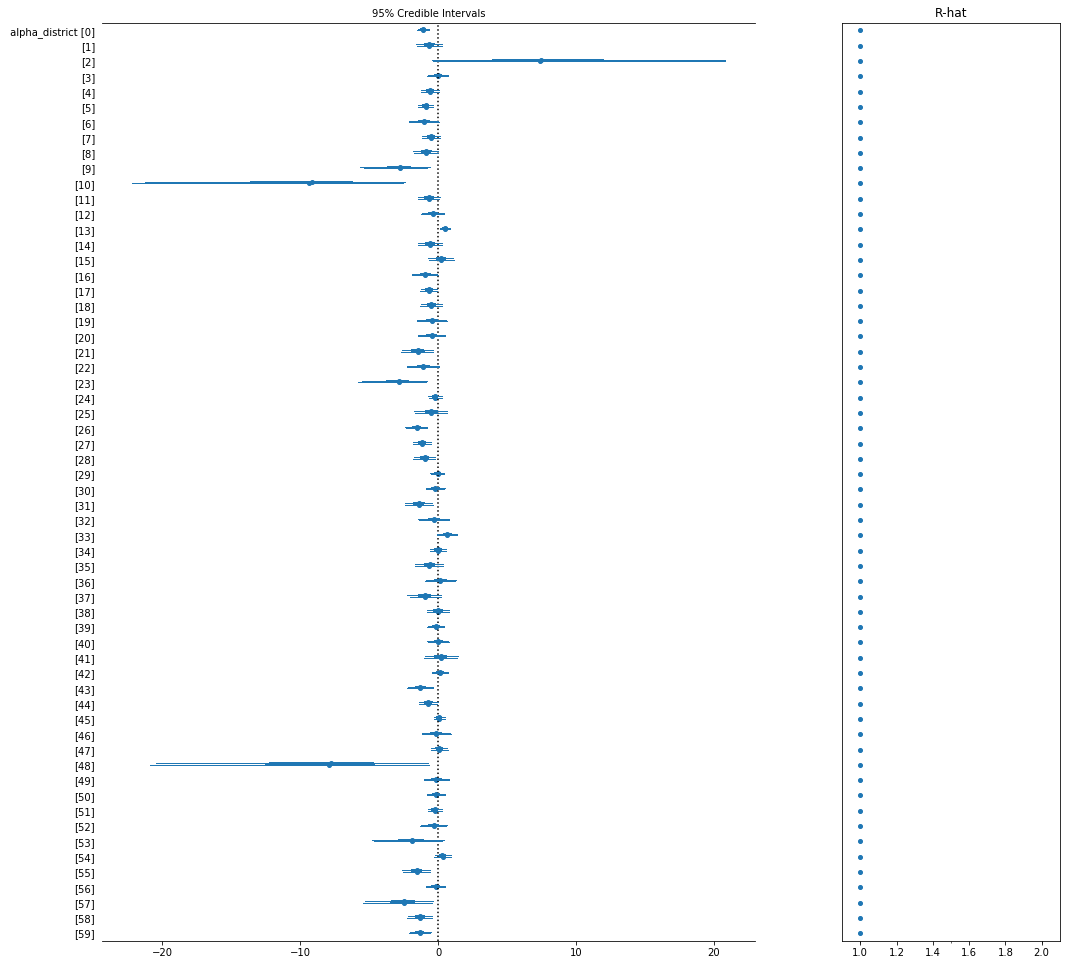

In [146]:
fig, ax = plt.subplots(figsize = (20, 15))
pm.forestplot(trace_A1);

In [147]:
pm.summary(trace_A1)

mean        sd  mc_error    hpd_2.5   hpd_97.5  \
alpha_district__0   -1.074384  0.214782  0.001769  -1.505960  -0.662558   
alpha_district__1   -0.654319  0.481134  0.003620  -1.577848   0.283805   
alpha_district__2    8.567936  6.000069  0.066057  -0.487281  20.770885   
alpha_district__3   -0.002567  0.372066  0.002764  -0.755343   0.718461   
alpha_district__4   -0.592193  0.335553  0.002835  -1.254801   0.054180   
alpha_district__5   -0.899241  0.274473  0.001904  -1.471189  -0.385057   
alpha_district__6   -1.019228  0.546239  0.004429  -2.089649   0.034980   
alpha_district__7   -0.513063  0.340488  0.002465  -1.170088   0.159644   
alpha_district__8   -0.863347  0.457294  0.003674  -1.781432  -0.005751   
alpha_district__9   -2.962432  1.290334  0.014124  -5.614256  -0.778532   
alpha_district__10 -10.463325  5.613797  0.076301 -21.547451  -2.292902   
alpha_district__11  -0.664271  0.396423  0.002668  -1.459827   0.103100   
alpha_district__12  -0.351302  0.419699  0.003042  -1.168145   0.477199   
alpha_district__13   0.522450  0.191999  0.001186   0.141902   0.884808   
alpha_district__14  -0.585672  0.458189  0.004035  -1.454523   0.309858   
alpha_district__15   0.213638  0.459829  0.003591  -0.666348   1.134924   
alpha_district__16  -0.927038  0.469873  0.003469  -1.866737  -0.037916   
alpha_district__17  -0.670984  0.311164  0.002139  -1.282570  -0.057568   
alpha_district__18  -0.485628  0.402127  0.003114  -1.285477   0.283601   
alpha_district__19  -0.435864  0.544021  0.004096  -1.537647   0.608384   
alpha_district__20  -0.480979  0.498880  0.003664  -1.438999   0.494008   
alpha_district__21  -1.483545  0.598410  0.005057  -2.671126  -0.381036   
alpha_district__22  -1.087473  0.606755  0.004720  -2.276831   0.068669   
alpha_district__23  -3.055409  1.317491  0.016219  -5.601583  -0.753777   
alpha_district__24  -0.214910  0.249139  0.001840  -0.690121   0.296976   
alpha_district__25  -0.501664  0.598573  0.003709  -1.700591   0.657983   
alpha_district__26  -1.551501  0.404364  0.003244  -2.342148  -0.784270   
alpha_district__27  -1.153618  0.333068  0.002570  -1.800203  -0.490543   
alpha_district__28  -0.971528  0.404014  0.002712  -1.785376  -0.203538   
alpha_district__29  -0.034134  0.258726  0.001885  -0.533738   0.461166   
alpha_district__30  -0.192743  0.348223  0.002663  -0.857490   0.495622   
alpha_district__31  -1.398714  0.516748  0.003780  -2.436120  -0.403562   
alpha_district__32  -0.300211  0.562251  0.003751  -1.451495   0.767947   
alpha_district__33   0.666801  0.366070  0.002570  -0.054753   1.375810   
alpha_district__34  -0.004157  0.293592  0.002168  -0.573559   0.570031   
alpha_district__35  -0.641223  0.515548  0.003438  -1.660542   0.380968   
alpha_district__36   0.161999  0.575287  0.004125  -0.932814   1.312711   
alpha_district__37  -0.994093  0.615370  0.005008  -2.210107   0.186023   
alpha_district__38   0.003213  0.404360  0.002625  -0.766355   0.810451   
alpha_district__39  -0.153665  0.316168  0.002189  -0.769831   0.467425   
alpha_district__40   0.005345  0.394007  0.002676  -0.778280   0.755486   
alpha_district__41   0.199744  0.618878  0.004345  -0.988667   1.455361   
alpha_district__42   0.139707  0.300252  0.002069  -0.461460   0.709126   
alpha_district__43  -1.309732  0.479261  0.003173  -2.236920  -0.332583   
alpha_district__44  -0.715288  0.347317  0.002811  -1.387358  -0.032918   
alpha_district__45   0.092554  0.213634  0.001512  -0.314579   0.513695   
alpha_district__46  -0.144658  0.523719  0.003615  -1.150257   0.909392   
alpha_district__47   0.094879  0.303901  0.002321  -0.480716   0.701730   
alpha_district__48  -9.030685  5.712522  0.058340 -20.798384  -0.738021   
alpha_district__49  -0.116259  0.467917  0.003572  -1.025281   0.791995   
alpha_district__50  -0.166756  0.336073  0.002613  -0.813583   0.513659   
alpha_district__51  -0.234998  0.260469  0.001909  -0.729051   0.294458   
alpha_district__52  -0.326839  0.484965  0.003915 

In [148]:
## A2
with pm.Model() as districtmulti_model:
    alpha = pm.Normal('alpha', 0, 10)
    sigma = pm.HalfCauchy('sigma', 2)
    alpha_district = pm.Normal('alpha_district', 0, sigma, shape=num_districts)
    p=pm.math.invlogit(alpha + alpha_district[bangladesh.district_id])
    o = pm.Bernoulli("contraception", p=p, observed=bangladesh['use.contraception'])

In [149]:
with districtmulti_model:
    trace_A2 = pm.sample(5000, tune=2000, step=pm.NUTS())

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha_district, sigma, alpha]
Sampling 2 chains: 100%|██████████| 14000/14000 [00:53<00:00, 262.44draws/s]


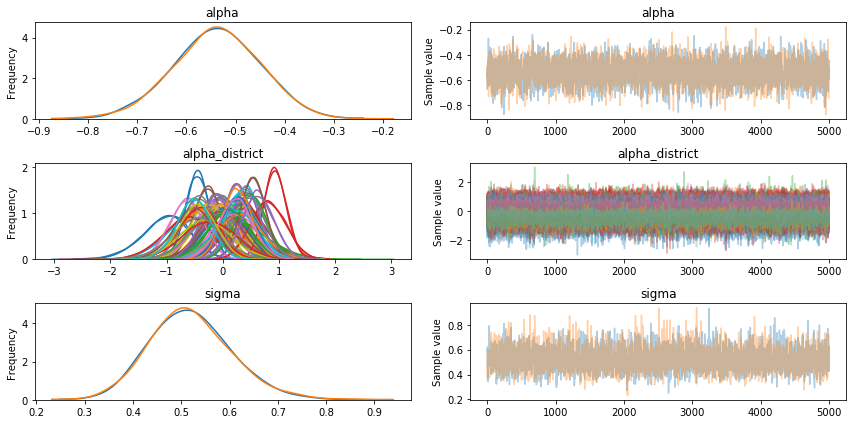

In [150]:
pm.traceplot(trace_A2);

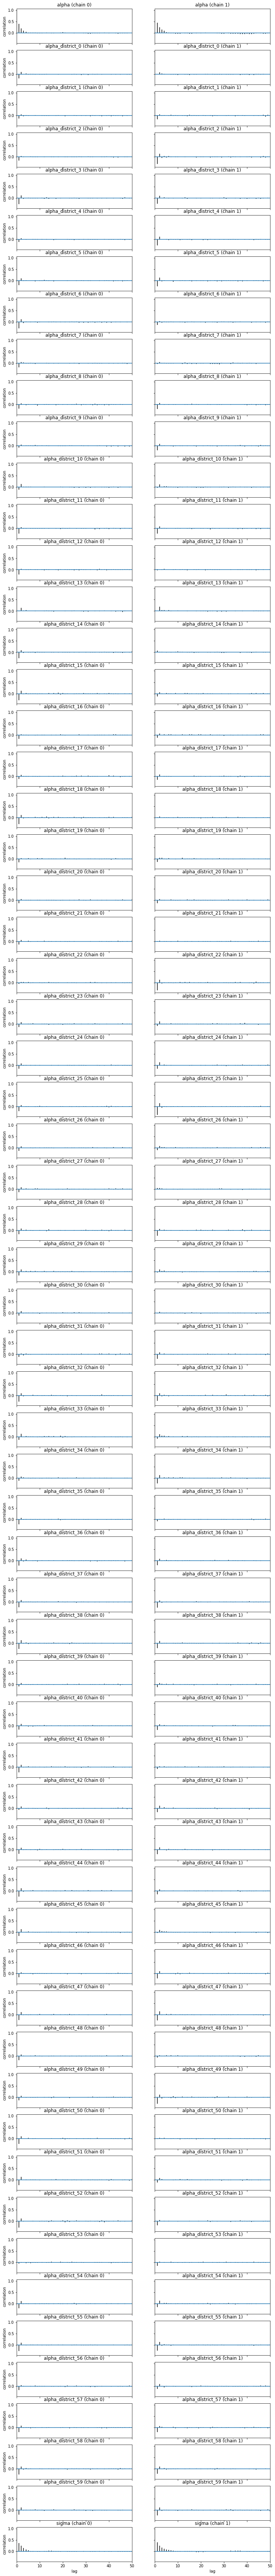

In [151]:
pm.autocorrplot(trace_A2, max_lag=50);

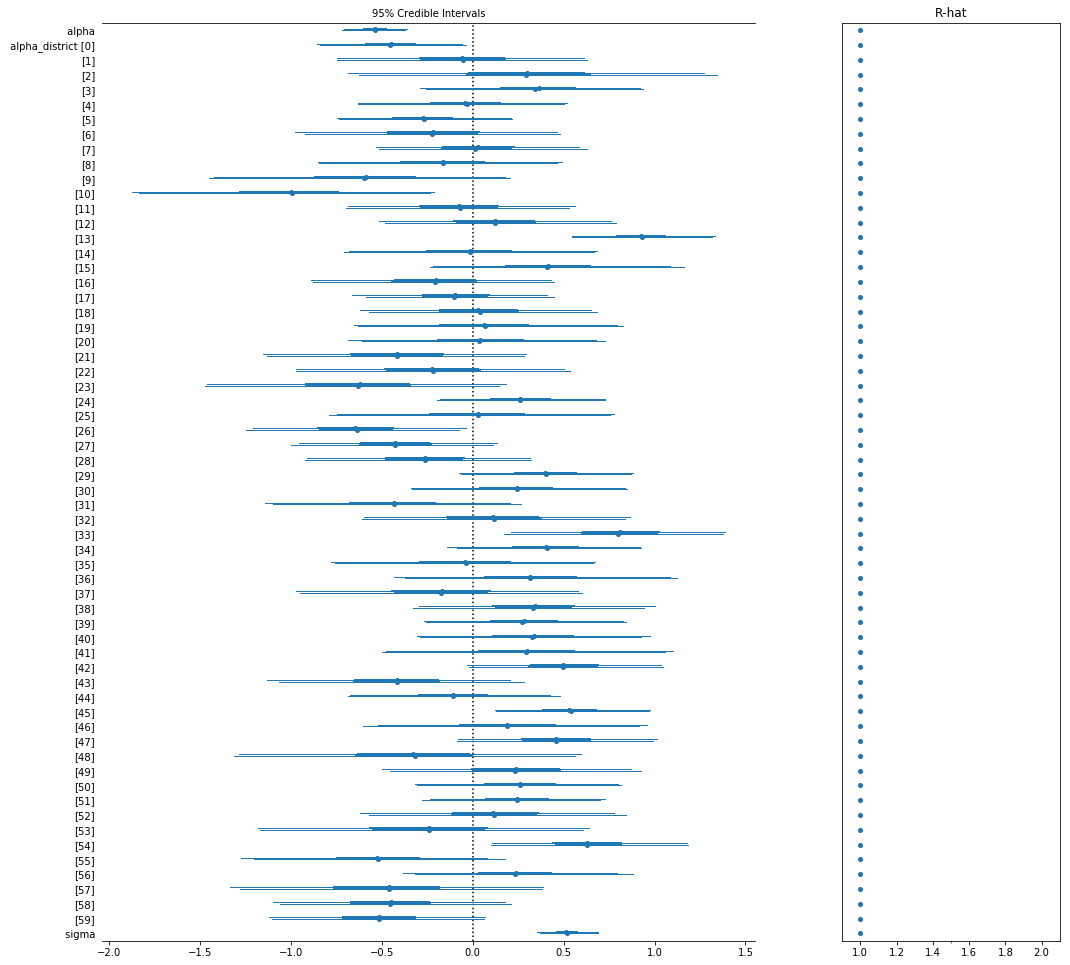

In [152]:
fig, ax = plt.subplots(figsize = (20, 15))
pm.forestplot(trace_A2);

In [153]:
pm.summary(trace_A2)

mean        sd  mc_error   hpd_2.5  hpd_97.5  \
alpha              -0.537971  0.088467  0.001338 -0.707745 -0.359930   
alpha_district__0  -0.455008  0.205416  0.002234 -0.848253 -0.047173   
alpha_district__1  -0.057700  0.350805  0.002929 -0.744597  0.626901   
alpha_district__2   0.311000  0.497145  0.004188 -0.656876  1.308394   
alpha_district__3   0.352648  0.308007  0.002746 -0.248296  0.958367   
alpha_district__4  -0.041420  0.288947  0.002925 -0.630574  0.508888   
alpha_district__5  -0.276628  0.245509  0.002079 -0.744496  0.212907   
alpha_district__6  -0.225539  0.367551  0.002836 -0.947870  0.480885   
alpha_district__7   0.022777  0.288957  0.003088 -0.541730  0.589933   
alpha_district__8  -0.172326  0.337033  0.003025 -0.836870  0.490492   
alpha_district__9  -0.603856  0.419905  0.004487 -1.451940  0.175741   
alpha_district__10 -1.019385  0.420416  0.005120 -1.875769 -0.240612   
alpha_district__11 -0.074115  0.317354  0.002483 -0.688216  0.551080   
alpha_district__12  0.121533  0.327335  0.003222 -0.494354  0.780105   
alpha_district__13  0.931524  0.199501  0.002504  0.548195  1.328179   
alpha_district__14 -0.020953  0.347347  0.003403 -0.682975  0.690150   
alpha_district__15  0.417487  0.345931  0.003102 -0.268721  1.086628   
alpha_district__16 -0.214326  0.338474  0.003396 -0.883605  0.440336   
alpha_district__17 -0.098915  0.270468  0.002290 -0.647203  0.412050   
alpha_district__18  0.033249  0.318767  0.002763 -0.601238  0.662941   
alpha_district__19  0.062253  0.373773  0.003467 -0.638931  0.815890   
alpha_district__20  0.040347  0.347686  0.003215 -0.639789  0.717181   
alpha_district__21 -0.423557  0.370860  0.003050 -1.156861  0.280872   
alpha_district__22 -0.226278  0.381271  0.003505 -0.972069  0.522664   
alpha_district__23 -0.642105  0.420856  0.004258 -1.487706  0.148878   
alpha_district__24  0.262377  0.233856  0.001952 -0.185643  0.730472   
alpha_district__25  0.025966  0.389537  0.002829 -0.746447  0.785449   
alpha_district__26 -0.649075  0.303077  0.002806 -1.243732 -0.066753   
alpha_district__27 -0.429997  0.283433  0.002644 -0.987037  0.116641   
alpha_district__28 -0.267730  0.315305  0.002633 -0.908975  0.321734   
...                      ...       ...       ...       ...       ...   
alpha_district__31 -0.441985  0.347298  0.002946 -1.105576  0.258132   
alpha_district__32  0.113998  0.375753  0.002999 -0.598523  0.854485   
alpha_district__33  0.811319  0.306108  0.003154  0.179764  1.372573   
alpha_district__34  0.407051  0.262805  0.002457 -0.108829  0.930876   
alpha_district__35 -0.040854  0.363610  0.002489 -0.743842  0.693645   
alpha_district__36  0.318312  0.382350  0.003151 -0.403470  1.108612   
alpha_district__37 -0.176839  0.395156  0.003063 -0.972520  0.580715   
alpha_district__38  0.336193  0.326098  0.002795 -0.302015  0.984401   
alpha_district__39  0.278462  0.279296  0.003002 -0.268447  0.827354   
alpha_district__40  0.333840  0.322373  0.002948 -0.283734  0.965798   
alpha_district__41  0.296883  0.396813  0.003594 -0.480642  1.091244   
alpha_district__42  0.499672  0.274508  0.002564 -0.035915  1.034514   
alpha_district__43 -0.423274  0.342781  0.003141 -1.114299  0.233137   
alpha_district__44 -0.113315  0.288796  0.002443 -0.688737  0.441056   
alpha_district__45  0.536306  0.216754  0.002051  0.127218  0.975326   
alpha_district__46  0.194740  0.382653  0.003015 -0.557938  0.942701   
alpha_district__47  0.460745  0.277284  0.002665 -0.073313  1.014637   
alpha_district__48 -0.331304  0.476254  0.004987 -1.310883  0.570432   
alpha_district__49  0.237728  0.354138  0.003227 -0.440689  0.939503   
alpha_district__50  0.258558  0.286805  0.002901 -0.308942  0.813584   
alpha_district__51  0.241958  0.246867  0.002394 -0.241866  0.729908   
alpha_district__52  0.117988  0.355966  0.002778 -0.615749  0.786926   
alpha_district__53 -0.249001  0.462302  0.004746 -1.139131  0.662080   
alpha_district__54  0.634907  0.275994  0.002859  0.104487  1.18

A3: ENTIRE: negative; district specific depends

In [24]:
## A4
with districtonly_model:
    ppc_A4_only = pm.sample_ppc(trace_A1)

100%|██████████| 5000/5000 [00:05<00:00, 924.06it/s] 


In [25]:
with districtmulti_model:
    ppc_A4_multi = pm.sample_ppc(trace_A2)

100%|██████████| 5000/5000 [00:08<00:00, 624.27it/s] 


In [40]:
bangladesh['districtonly'] = ppc_A4_only['contraception'].mean(axis = 0)
bangladesh['districtmulti'] = ppc_A4_multi['contraception'].mean(axis = 0)

In [43]:
bangladesh

woman  district  use.contraception  living.children  age.centered  \
0         1         1                  0                4       18.4400   
1         2         1                  0                1       -5.5599   
2         3         1                  0                3        1.4400   
3         4         1                  0                4        8.4400   
4         5         1                  0                1      -13.5590   
5         6         1                  0                1      -11.5600   
6         7         1                  0                4       18.4400   
7         8         1                  0                4       -3.5599   
8         9         1                  0                2       -5.5599   
9        10         1                  0                4        1.4400   
10       11         1                  1                1      -11.5600   
11       12         1                  0                1       -2.5599   
12       13         1                  0                2       -4.5599   
13       14         1                  0                4        5.4400   
14       15         1                  0                4       -0.5599   
15       16         1                  1                4        4.4400   
16       17         1                  0                1       -5.5599   
17       18         1                  1                4       -0.5599   
18       19         1                  1                2       -6.5599   
19       20         1                  0                3       -3.5600   
20       21         1                  0                1       -4.5599   
21       22         1                  0                1       -9.5599   
22       23         1                  0                4        2.4400   
23       24         1                  1                3        2.4400   
24       25         1                  1                2       -4.5599   
25       26         1                  0                4       14.4400   
26       27         1                  1                1       -6.5599   
27       28         1                  1                2       -3.5599   
28       29         1                  1                2       -5.5599   
29       30         1                  1                2       -1.5599   
...     ...       ...                ...              ...           ...   
1904   1905        61                  1                1       -9.5599   
1905   1906        61                  0                4        5.4400   
1906   1907        61                  0                3       11.4400   
1907   1908        61                  0                3       -2.5599   
1908   1909        61                  0                2       -7.5599   
1909   1910        61                  0                2       -5.5599   
1910   1911        61                  0                2       -8.5599   
1911   1912        61                  0                4       19.4400   
1912   1913        61                  0                4        0.4400   
1913   1914        61                  0                3        8.4400   
1914   1915        61                  0                2       -7.5599   
1915   1916        61                  1                4        1.4400   
1916   1917        61                  0                1       -9.5599   
1917   1918        61                  1                2       -0.5599   
1918   1919        61                  0                2       -9.5599   
1919   1920        61                  1                1      -10.5590   
1920   1921        61                  0                4       11.4400   
1921   1922        61                  0                4        8.4400   
1922   1923        61                  1                1      -11.5590   
1923   1924        61                  0                4        1.4400   
1924   1925        61                  0                2       -5.5600   
1925   1926        61          

In [66]:
district_only = np.empty(num_districts)
district_multi = np.empty(num_districts)
district_n = np.empty(num_districts)

for k, v in bangladesh.groupby('district_id'):
    district_only[k] = v['districtonly'].mean()
    district_multi[k] = v['districtmulti'].mean()
    district_n[k] = len(v)

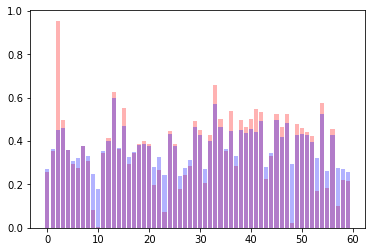

In [61]:
plt.bar(np.arange(num_districts), district_only, color='red', alpha = 0.3, label='district_only');
plt.bar(np.arange(num_districts), district_multi, color='blue', alpha = 0.3, label='district_multi');

In [62]:
bangladesh[bangladesh.district_id == 2]

## small samples in district 2

woman  district  use.contraception  living.children  age.centered  urban  \
137    138         3                  1                4       -3.5599      1   
138    139         3                  1                1       -8.5599      1   

     district_id  districtonly  districtmulti  
137            2        0.9566         0.4472  
138            2        0.9542         0.4532

In [107]:
def invlogit(x):
    return np.exp(x) / (1 + np.exp(x))

def trace_or_zero(trace, name):
    if name in trace.varnames:
        return trace[name]
    else:
        return np.zeros(2*len(trace))
    
def model_pp(tracedict, ix):
    temp = tracedict['alpha'] + tracedict['alpha_district'][:, ix]
    return temp

def compute_pp(trace, tsize, paramnames, sampdistrib, invlink, inner_pp, ix):
    tdict={}
    for pn in paramnames:
        tdict[pn] = trace_or_zero(trace, pn)
    print(tdict.keys(), tsize)
    tl=tsize
    pp = np.empty(tl)
    temp = inner_pp(tdict, ix)
    pp = sampdistrib(invlink(temp))
    return pp

from scipy.stats import bernoulli
def bern(p_array):
    return bernoulli.rvs(p=p_array)


In [109]:
district_only_new = np.empty(num_districts)
district_multi_new = np.empty(num_districts)

for i in range(num_districts):
    ppens = compute_pp(trace_A1, 2 * len(trace_A1), ['alpha', 'alpha_district'], bern, invlogit, model_pp, i)
    district_only_new[i] = ppens.mean()
    
    ppens = compute_pp(trace_A2, 2 * len(trace_A2), ['alpha', 'alpha_district'], bern, invlogit, model_pp, i)
    district_multi_new[i] = ppens.mean()

dict_keys(['alpha', 'alpha_district']) 10000
dict_keys(['alpha', 'alpha_district']) 10000
dict_keys(['alpha', 'alpha_district']) 10000
dict_keys(['alpha', 'alpha_district']) 10000
dict_keys(['alpha', 'alpha_district']) 10000
dict_keys(['alpha', 'alpha_district']) 10000
dict_keys(['alpha', 'alpha_district']) 10000
dict_keys(['alpha', 'alpha_district']) 10000
dict_keys(['alpha', 'alpha_district']) 10000
dict_keys(['alpha', 'alpha_district']) 10000
dict_keys(['alpha', 'alpha_district']) 10000
dict_keys(['alpha', 'alpha_district']) 10000
dict_keys(['alpha', 'alpha_district']) 10000
dict_keys(['alpha', 'alpha_district']) 10000
dict_keys(['alpha', 'alpha_district']) 10000
dict_keys(['alpha', 'alpha_district']) 10000
dict_keys(['alpha', 'alpha_district']) 10000
dict_keys(['alpha', 'alpha_district']) 10000
dict_keys(['alpha', 'alpha_district']) 10000
dict_keys(['alpha', 'alpha_district']) 10000
dict_keys(['alpha', 'alpha_district']) 10000
dict_keys(['alpha', 'alpha_district']) 10000
dict_keys(

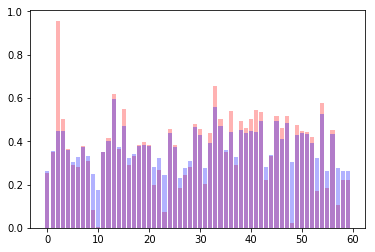

In [110]:
plt.bar(np.arange(num_districts), district_only_new, color='red', alpha = 0.3, label='district_only');
plt.bar(np.arange(nbum_districts), district_multi_new, color='blue', alpha = 0.3, label='district_multi');

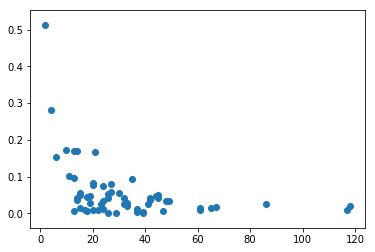

In [111]:
plt.scatter(district_n, np.abs(district_only_new - district_multi_new));

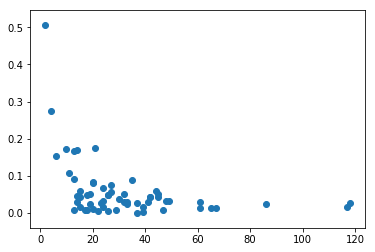

In [68]:
# A5
plt.scatter(district_n, np.abs(district_only - district_multi));

In [ ]:
# difference inv prop to n 

## Part B.

Let us now fit a model with both varying intercepts by `district_id` (like we did in the varying effects model above) and varying slopes of `urban` by `district_id`. To do this, we will 

- (a) have an overall intercept, call it `alpha`
- (b) have an overall slope of `urban`, call it `beta`.
- (c) have district specific intercepts `alpha_district`
- (d) district specific slopes for `urban`, `beta_district`
- (e) model the co-relation between these slopes and intercepts. 

We have not modelled covariance and correlation before, so look at http://am207.info/wiki/corr.html for notes on how this is done.

To see the ideas behind this, see section 13.2.2 on the income data  from your textbook (included as a pdf in this zip). Feel free to use [code with attribution from Osvaldo Martin](https://github.com/aloctavodia/Statistical-Rethinking-with-Python-and-PyMC3/blob/master/Chp_13.ipynb)..with attribution and understanding...there is some sweet pymc3 technical wrangling in there.

**B1** Write down the model as a pymc3 specification and look at its graph. Note that this model builds a 60 by 2 matrix with `alpha_district` values in the first column and `beta_district` values in the second. By assumption, the first column and the second column have correlation structure given by an LKJ prior, but there is no explicit correlation among the rows. In other words, the correlation matrix is 2x2 (not 60x60). Make sure to obtain the value of the off-diagonal correlation as a `pm.Deterministic`. (See Osvaldo Martin's code above)

**B2**: Sample from the posterior of the model above *with a target acceptance rate of .9 or more*. (Sampling takes me 7 minutes 30 seconds on my 2013 Macbook Air). Comment on the quality of the samples obtained.

**B3** Propose a method based on the reparametrization trick for multi-variate gaussians) of improving the quality of the samples obtained and implement it. (A hint can be obtained from here: https://docs.pymc.io/api/distributions/multivariate.html#pymc3.distributions.multivariate.MvNormal . Using that hint lowered the sampling time to 2.5 minutes on my laptop).

**B4** Inspect the trace of the correlation between the intercepts and slopes, plotting the correlation marginal. What does this correlation tell you about the pattern of contraceptive use in the sample? It might help to plot the mean (or median) varying effect estimates for both the intercepts and slopes, by district. Then you can visualize the correlation and maybe more easily think through what it means to have a particular correlation. Also plot the predicted proportion of women using contraception, with urban women on one axis and rural on the other.  Finally, also plot the difference between urban and rural probabilities against rural probabilities. All of these will help you interpret your findings. (Hint: think in terms of low or high rural contraceptive use)

**B5** Add additional "slope" terms (one-by-one) into the model for 

- (a) the centered-age of the women and 
- (b) an indicator for whether the women have a small number or large number of existing kids in the house (you can treat 1-2 kids as low, 3-4 as high, but you might want to experiment with this split). 

Are any of these effects significant? Are any significant effects similar over the urban/rural divide?

**B6** Use WAIC to compare your models. What are your conclusions?

In [74]:
# B1
with pm.Model() as correlation_model:
    alpha = pm.Normal('alpha', 0, 10)
    beta = pm.Normal('beta', 0, 1)
    
    sd_dist = pm.HalfCauchy.dist(beta=2)
    packed_chol = pm.LKJCholeskyCov('chol_cov', eta=2, n=2, sd_dist=sd_dist)
    
    # compute the covariance matrix
    chol = pm.expand_packed_triangular(2, packed_chol, lower=True)
    cov = T.dot(chol, chol.T)
    
    # Extract the standard deviations and rho
    sigma_ab = pm.Deterministic('sigma', T.sqrt(T.diag(cov)))
    corr = T.diag(sigma_ab**-1).dot(cov.dot(T.diag(sigma_ab**-1)))
    r = pm.Deterministic('Rho', corr[np.triu_indices(2, k=1)])
    
    mu = pm.MvNormal('ab_cafe', mu=T.stack([alpha, beta]), chol=chol, shape=(num_districts, 2))
    
    alpha_district = pm.Deterministic('alpha_district', mu[:, 0])
    beta_district = pm.Deterministic('beta_district', mu[:, 1])
    
    p = pm.math.invlogit(mu[bangladesh.district_id.values, 0] + mu[bangladesh.district_id.values, 1] * bangladesh.urban.values
                )
    o = pm.Bernoulli('contraception', p=p, observed=bangladesh['use.contraception'])

In [75]:
# B2
with correlation_model:
    correlation_model_trace = pm.sample(5000, tune = 2000, target_accept = 0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ab_cafe, chol_cov, beta, alpha]
Sampling 2 chains: 100%|██████████| 14000/14000 [05:05<00:00, 45.85draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


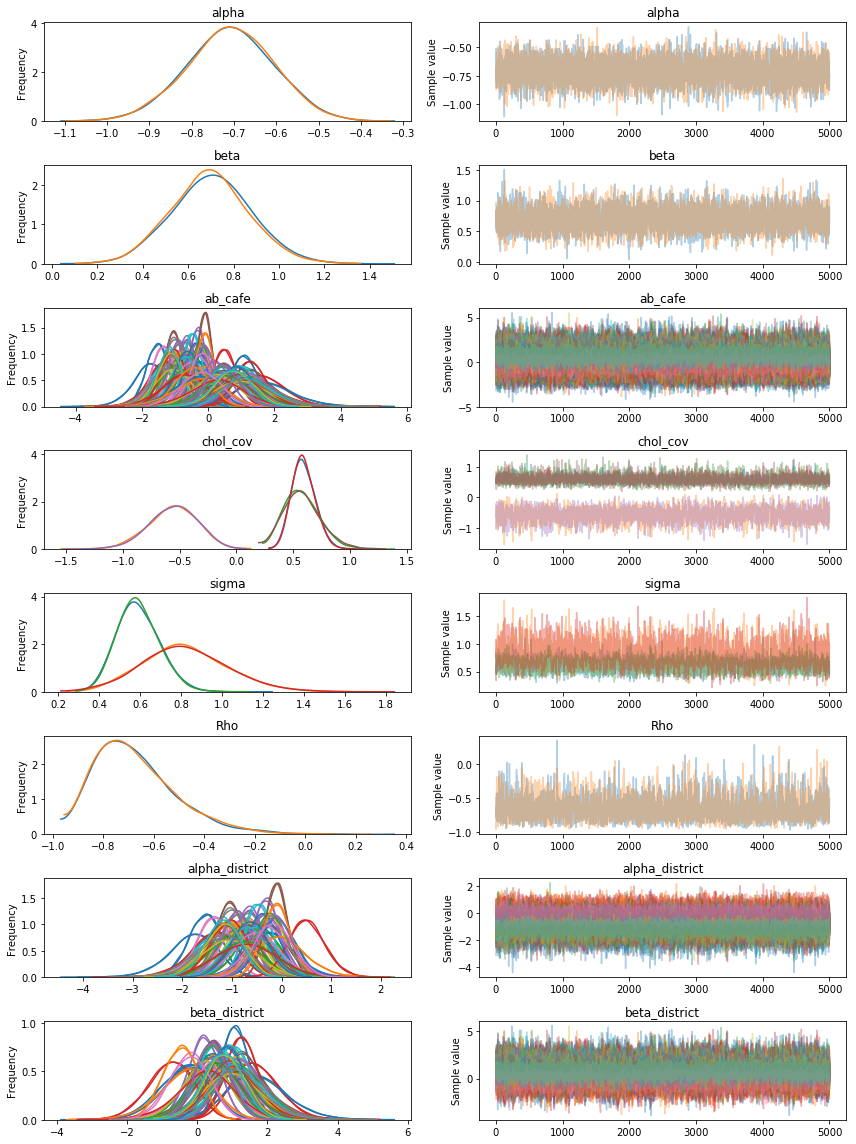

In [76]:
pm.traceplot(correlation_model_trace);

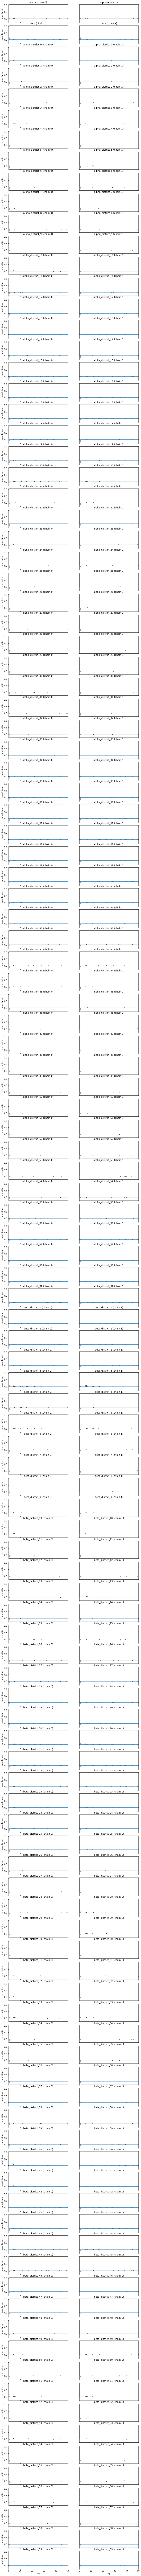

In [85]:
pm.autocorrplot(correlation_model_trace, varnames=['alpha', 'beta', 'alpha_district', 'beta_district'], max_lag=50);

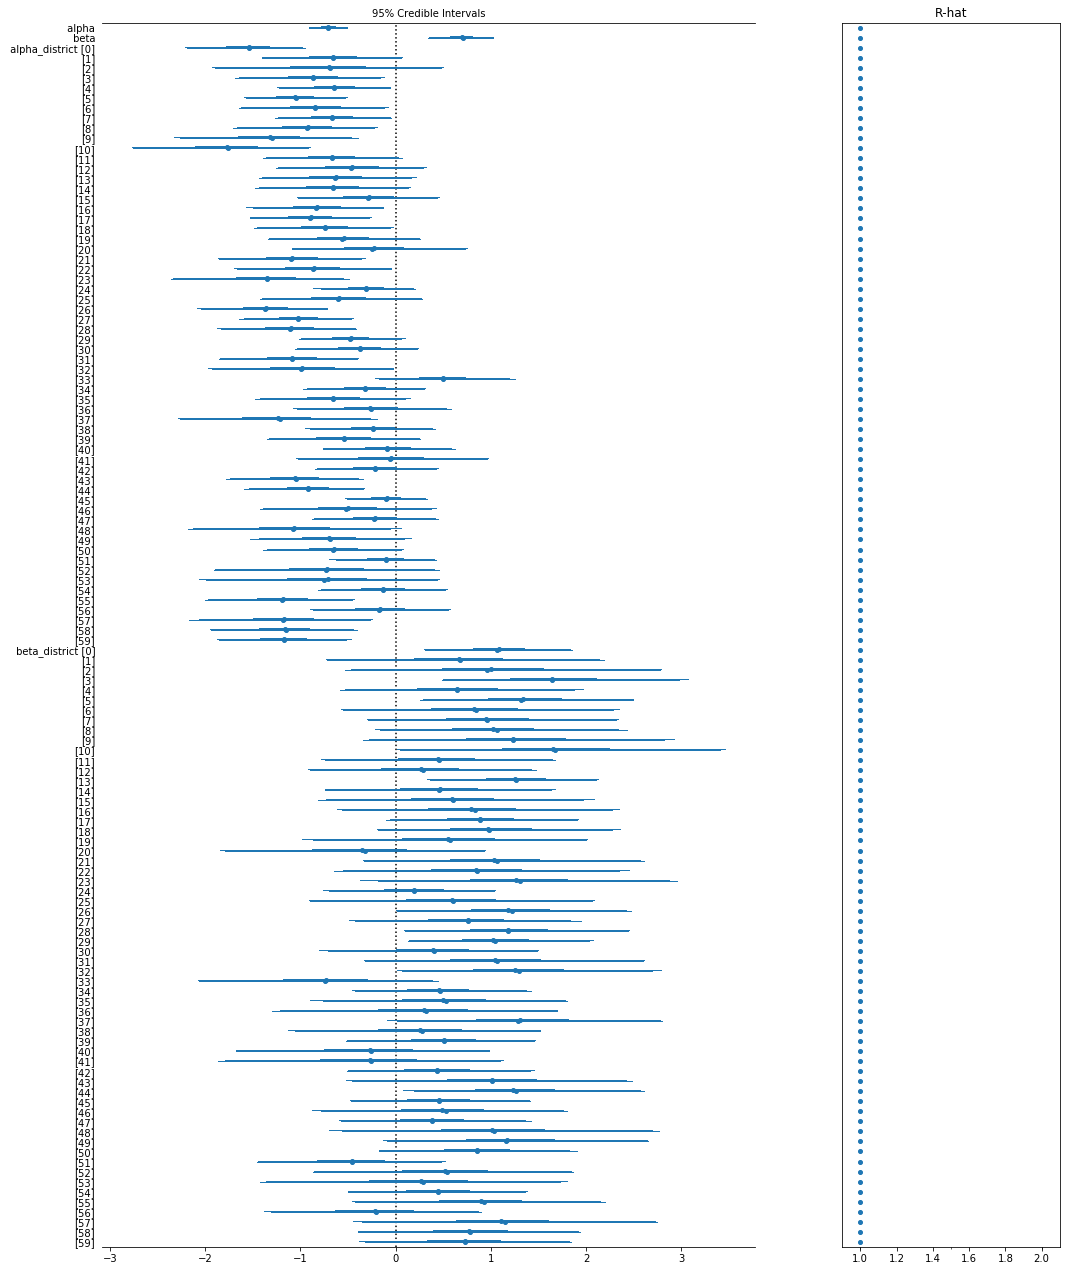

In [83]:
fig, ax = plt.subplots(figsize = (20, 20))
pm.forestplot(correlation_model_trace, varnames=['alpha', 'beta', 'alpha_district', 'beta_district']);

In [84]:
pm.summary(correlation_model_trace, varnames=['alpha', 'beta', 'alpha_district', 'beta_district'])

mean        sd  mc_error   hpd_2.5  hpd_97.5  \
alpha              -0.708565  0.102617  0.001201 -0.906108 -0.507484   
beta                0.700597  0.173257  0.002520  0.348759  1.024908   
alpha_district__0  -1.551541  0.320239  0.003729 -2.198357 -0.959837   
alpha_district__1  -0.661916  0.373955  0.003333 -1.400901  0.061885   
alpha_district__2  -0.701018  0.605121  0.006009 -1.916725  0.483574   
alpha_district__3  -0.879594  0.389306  0.004629 -1.647817 -0.123050   
alpha_district__4  -0.647679  0.299467  0.002810 -1.236441 -0.054812   
alpha_district__5  -1.056365  0.270824  0.002416 -1.568720 -0.502578   
alpha_district__6  -0.856995  0.390544  0.003459 -1.620346 -0.086805   
alpha_district__7  -0.672632  0.311043  0.002472 -1.252057 -0.057458   
alpha_district__8  -0.937502  0.376238  0.003716 -1.700498 -0.226096   
alpha_district__9  -1.332821  0.476001  0.005247 -2.262444 -0.395160   
alpha_district__10 -1.797210  0.481230  0.005618 -2.780090 -0.914827   
alpha_district__11 -0.673619  0.361638  0.002677 -1.371077  0.057107   
alpha_district__12 -0.463229  0.395869  0.003838 -1.214752  0.337123   
alpha_district__13 -0.635433  0.403206  0.005583 -1.395596  0.210398   
alpha_district__14 -0.660308  0.407152  0.003671 -1.449758  0.149939   
alpha_district__15 -0.285348  0.382420  0.003883 -1.041005  0.436146   
alpha_district__16 -0.834974  0.360405  0.003253 -1.520835 -0.121134   
alpha_district__17 -0.903720  0.321041  0.002987 -1.533184 -0.268733   
alpha_district__18 -0.750219  0.363929  0.003737 -1.489332 -0.054548   
alpha_district__19 -0.554438  0.403812  0.003457 -1.337638  0.247697   
alpha_district__20 -0.231419  0.464019  0.006119 -1.100783  0.736027   
alpha_district__21 -1.099862  0.391517  0.003733 -1.865160 -0.336229   
alpha_district__22 -0.873186  0.417510  0.003783 -1.682225 -0.044992   
alpha_district__23 -1.379640  0.467668  0.004917 -2.351117 -0.521053   
alpha_district__24 -0.310571  0.260606  0.002285 -0.823372  0.198476   
alpha_district__25 -0.597742  0.426332  0.003527 -1.414558  0.271062   
alpha_district__26 -1.379951  0.341839  0.003199 -2.060648 -0.717794   
alpha_district__27 -1.029726  0.296720  0.002601 -1.628986 -0.470659   
...                      ...       ...       ...       ...       ...   
beta_district__30   0.389656  0.576760  0.005726 -0.753292  1.500353   
beta_district__31   1.076108  0.739231  0.008749 -0.335230  2.598095   
beta_district__32   1.310275  0.691418  0.008106  0.010658  2.721526   
beta_district__33  -0.760533  0.642488  0.010699 -2.047830  0.444040   
beta_district__34   0.453934  0.472783  0.004018 -0.425934  1.414973   
beta_district__35   0.504341  0.669897  0.006362 -0.820331  1.814568   
beta_district__36   0.291290  0.747437  0.007779 -1.243566  1.717087   
beta_district__37   1.340279  0.725268  0.009114  0.016591  2.850186   
beta_district__38   0.255951  0.660866  0.006681 -1.112077  1.508475   
beta_district__39   0.499611  0.503584  0.004840 -0.519789  1.456250   
beta_district__40  -0.311487  0.688676  0.009220 -1.702054  0.954761   
beta_district__41  -0.308210  0.756459  0.010738 -1.799894  1.150398   
beta_district__42   0.433096  0.496116  0.005058 -0.534114  1.405203   
beta_district__43   1.030397  0.735378  0.007874 -0.471481  2.488407   
beta_district__44   1.281081  0.627222  0.007337  0.110107  2.565188   
beta_district__45   0.457533  0.478660  0.005113 -0.452673  1.428797   
beta_district__46   0.511763  0.660599  0.006586 -0.865414  1.749221   
beta_district__47   0.380484  0.504200  0.003999 -0.578626  1.398036   
beta_district__48   1.046203  0.840956  0.009095 -0.560433  2.814996   
beta_district__49   1.221898  0.701719  0.009306 -0.114295  2.643233   
beta_district__50   0.864245  0.520373  0.005751 -0.187039  1.850667   
beta_district__51  -0.474149  0.505875  0.007611 -1.445262  0.505468   
beta_district__52   0.523105  0.687340  0.007146 -0.842883  1.869594   
beta_district__53   0.241844  0.799113  0.010016 -1.364468  1.79

In [88]:
## B3
with pm.Model() as correlation_model2:
    alpha = pm.Normal('alpha', 0, 10)
    beta = pm.Normal('beta', 0, 1)
    
    sd_dist = pm.HalfCauchy.dist(beta=2)
    packed_chol = pm.LKJCholeskyCov('chol_cov', eta=2, n=2, sd_dist=sd_dist)
    
    # compute the covariance matrix
    chol = pm.expand_packed_triangular(2, packed_chol, lower=True)
    cov = T.dot(chol, chol.T)
    
    # Extract the standard deviations and rho
    sigma_ab = pm.Deterministic('sigma', T.sqrt(T.diag(cov)))
    corr = T.diag(sigma_ab**-1).dot(cov.dot(T.diag(sigma_ab**-1)))
    r = pm.Deterministic('Rho', corr[np.triu_indices(2, k=1)])
    
    mu_raw = pm.Normal('mu_raw', mu=0, sd=1, shape=(num_districts, 2))
    mu = T.stack([alpha,beta])+T.dot(chol,mu_raw.T).T
    #vals = pm.Deterministic('vals', tt.dot(chol, vals_raw.T).T)
    
    alpha_district = pm.Deterministic('alpha_district', mu[:, 0])
    beta_district = pm.Deterministic('beta_district', mu[:, 1])
    
    p = pm.math.invlogit(mu[bangladesh.district_id.values, 0] + mu[bangladesh.district_id.values, 1] * bangladesh.urban.values
                )
    o = pm.Bernoulli('contraception', p=p, observed=bangladesh['use.contraception'])

In [89]:
with correlation_model2:
    correlation_model_trace2 = pm.sample(5000, tune = 2000, target_accept = 0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_raw, chol_cov, beta, alpha]
Sampling 2 chains: 100%|██████████| 14000/14000 [02:48<00:00, 83.05draws/s] 


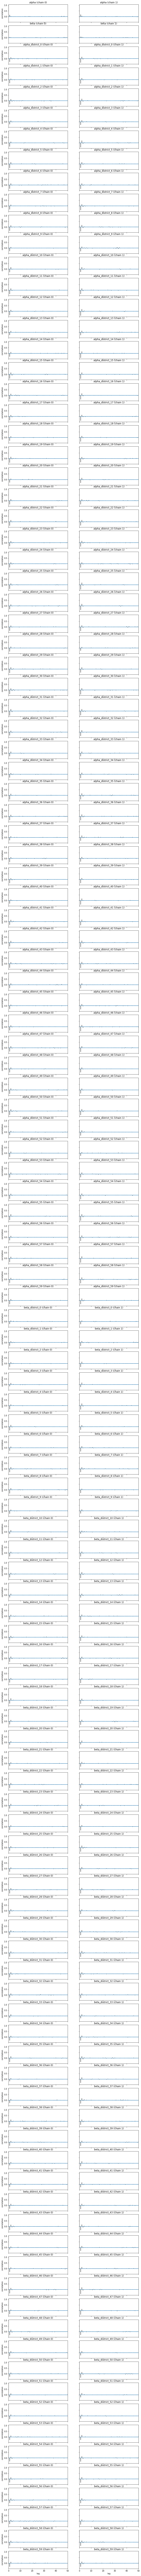

In [90]:
pm.autocorrplot(correlation_model_trace2, varnames=['alpha', 'beta', 'alpha_district', 'beta_district'], max_lag=50);

In [91]:
pm.summary(correlation_model_trace2, varnames=['alpha', 'beta', 'alpha_district', 'beta_district'])

mean        sd  mc_error   hpd_2.5  hpd_97.5  \
alpha              -0.709686  0.101958  0.001358 -0.909877 -0.513198   
beta                0.702064  0.173333  0.002034  0.347973  1.033254   
alpha_district__0  -1.553173  0.323626  0.002647 -2.183325 -0.918615   
alpha_district__1  -0.662896  0.369320  0.002520 -1.402435  0.042379   
alpha_district__2  -0.685801  0.618231  0.004831 -1.935682  0.529156   
alpha_district__3  -0.876458  0.395245  0.003075 -1.649337 -0.096131   
alpha_district__4  -0.649062  0.296611  0.002087 -1.244743 -0.087037   
alpha_district__5  -1.056393  0.269159  0.002004 -1.590034 -0.535359   
alpha_district__6  -0.859196  0.391007  0.002450 -1.666316 -0.123915   
alpha_district__7  -0.671125  0.309317  0.002580 -1.284971 -0.072733   
alpha_district__8  -0.937561  0.376800  0.002979 -1.700227 -0.232007   
alpha_district__9  -1.343182  0.471527  0.004125 -2.277789 -0.444461   
alpha_district__10 -1.793993  0.481694  0.004058 -2.770850 -0.914104   
alpha_district__11 -0.676416  0.350704  0.002515 -1.365138  0.009487   
alpha_district__12 -0.471368  0.392587  0.002531 -1.248058  0.289227   
alpha_district__13 -0.638021  0.398730  0.003274 -1.385072  0.179318   
alpha_district__14 -0.665827  0.405361  0.002936 -1.511747  0.086613   
alpha_district__15 -0.281267  0.385968  0.003005 -1.055812  0.464508   
alpha_district__16 -0.839590  0.361290  0.002804 -1.567258 -0.131429   
alpha_district__17 -0.905491  0.324575  0.002030 -1.540660 -0.260941   
alpha_district__18 -0.750549  0.366221  0.003019 -1.480993 -0.033089   
alpha_district__19 -0.559146  0.393588  0.002582 -1.334406  0.202846   
alpha_district__20 -0.241413  0.458274  0.003934 -1.095617  0.696931   
alpha_district__21 -1.096023  0.397577  0.002972 -1.858418 -0.309231   
alpha_district__22 -0.875967  0.405903  0.003123 -1.674184 -0.086823   
alpha_district__23 -1.378298  0.473424  0.003772 -2.336545 -0.476539   
alpha_district__24 -0.318847  0.261921  0.001937 -0.817083  0.219534   
alpha_district__25 -0.593649  0.426403  0.002935 -1.414985  0.256040   
alpha_district__26 -1.377700  0.348531  0.002374 -2.057740 -0.701092   
alpha_district__27 -1.035242  0.298258  0.002081 -1.632821 -0.458263   
...                      ...       ...       ...       ...       ...   
beta_district__30   0.392286  0.585819  0.003953 -0.821087  1.487668   
beta_district__31   1.068193  0.741694  0.006726 -0.438147  2.540848   
beta_district__32   1.323090  0.707755  0.006645 -0.032979  2.723921   
beta_district__33  -0.743468  0.645475  0.006455 -1.982520  0.534630   
beta_district__34   0.455989  0.475116  0.003391 -0.478640  1.392699   
beta_district__35   0.523379  0.668743  0.005025 -0.861605  1.791155   
beta_district__36   0.288235  0.755383  0.005966 -1.242279  1.773787   
beta_district__37   1.332513  0.723438  0.006865 -0.046105  2.814184   
beta_district__38   0.258940  0.657173  0.004545 -1.134364  1.482821   
beta_district__39   0.496148  0.509465  0.003623 -0.488430  1.497392   
beta_district__40  -0.312443  0.700005  0.006426 -1.727554  0.996447   
beta_district__41  -0.303562  0.758870  0.006612 -1.873734  1.060645   
beta_district__42   0.444943  0.489922  0.003879 -0.495735  1.433970   
beta_district__43   1.038091  0.721984  0.005767 -0.358313  2.508282   
beta_district__44   1.279208  0.624387  0.004627  0.115473  2.567213   
beta_district__45   0.461111  0.481418  0.003753 -0.475979  1.433689   
beta_district__46   0.517474  0.651246  0.004743 -0.673497  1.890921   
beta_district__47   0.389640  0.499568  0.003608 -0.587058  1.357982   
beta_district__48   1.054679  0.825451  0.006199 -0.548460  2.701160   
beta_district__49   1.228112  0.706409  0.005767 -0.108554  2.670002   
beta_district__50   0.868558  0.527239  0.003786 -0.169961  1.907199   
beta_district__51  -0.454002  0.504140  0.004310 -1.446241  0.527110   
beta_district__52   0.516463  0.691913  0.005620 -0.859722  1.870416   
beta_district__53   0.250878  0.787427  0.006955 -1.368599  1.74

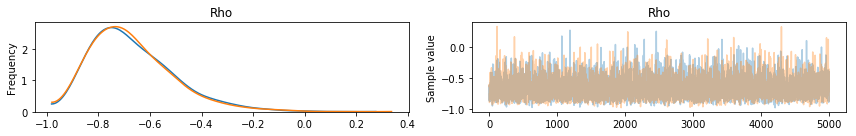

In [93]:
# B4
pm.traceplot(correlation_model_trace2, varnames=['Rho']);

## negative --> higher beta (given a district, higher positive difference for city/rural then lower average level for rural area)

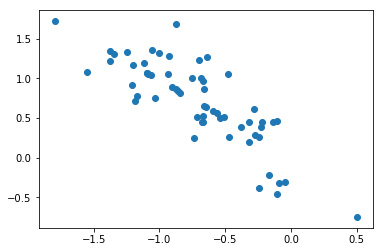

In [100]:
plt.scatter(correlation_model_trace2['alpha_district'].mean(axis = 0), correlation_model_trace2['beta_district'].mean(axis = 0))

In [112]:
def model_pp_slope(tracedict, ix):
    temp = tracedict['alpha'] + tracedict['alpha_district'][:, ix] + tracedict['beta'] + tracedict['beta_district'][:, ix]  
    return temp

In [113]:
rural = np.empty(num_districts)
city = np.empty(num_districts)

for i in range(num_districts):
    ppens = compute_pp(correlation_model_trace2, 2 * len(correlation_model_trace2), ['alpha', 'alpha_district','beta','beta_district'], bern, invlogit, model_pp, i)
    rural[i] = ppens.mean()
    
    ppens = compute_pp(correlation_model_trace2, 2 * len(correlation_model_trace2), ['alpha', 'alpha_district','beta','beta_district'], bern, invlogit, model_pp_slope, i)
    city[i] = ppens.mean()

dict_keys(['alpha', 'alpha_district', 'beta', 'beta_district']) 10000
dict_keys(['alpha', 'alpha_district', 'beta', 'beta_district']) 10000
dict_keys(['alpha', 'alpha_district', 'beta', 'beta_district']) 10000
dict_keys(['alpha', 'alpha_district', 'beta', 'beta_district']) 10000
dict_keys(['alpha', 'alpha_district', 'beta', 'beta_district']) 10000
dict_keys(['alpha', 'alpha_district', 'beta', 'beta_district']) 10000
dict_keys(['alpha', 'alpha_district', 'beta', 'beta_district']) 10000
dict_keys(['alpha', 'alpha_district', 'beta', 'beta_district']) 10000
dict_keys(['alpha', 'alpha_district', 'beta', 'beta_district']) 10000
dict_keys(['alpha', 'alpha_district', 'beta', 'beta_district']) 10000
dict_keys(['alpha', 'alpha_district', 'beta', 'beta_district']) 10000
dict_keys(['alpha', 'alpha_district', 'beta', 'beta_district']) 10000
dict_keys(['alpha', 'alpha_district', 'beta', 'beta_district']) 10000
dict_keys(['alpha', 'alpha_district', 'beta', 'beta_district']) 10000
dict_keys(['alpha', 

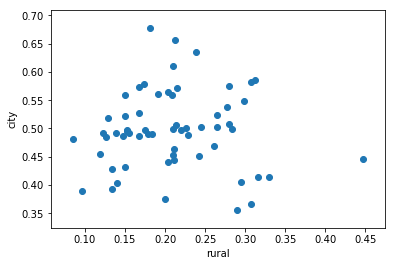

In [115]:
plt.scatter(rural, city)
plt.xlabel('rural')
plt.ylabel("city")

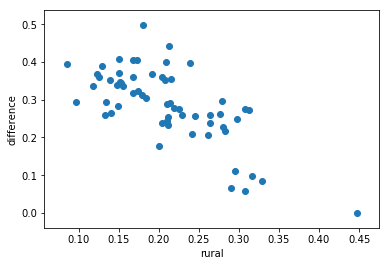

In [117]:
plt.scatter(rural, np.abs(rural - city))
plt.xlabel('rural')
plt.ylabel("difference")

In [119]:
## B5a

with pm.Model() as centeredwomen_model:
    alpha = pm.Normal('alpha', 0, 10)
    beta = pm.Normal('beta', 0, 1)
    beta_women = pm.Normal('beta_women', 0, 1)
    
    sd_dist = pm.HalfCauchy.dist(beta=2)
    packed_chol = pm.LKJCholeskyCov('chol_cov', eta=2, n=2, sd_dist=sd_dist)
    
    # compute the covariance matrix
    chol = pm.expand_packed_triangular(2, packed_chol, lower=True)
    cov = T.dot(chol, chol.T)
    
    # Extract the standard deviations and rho
    sigma_ab = pm.Deterministic('sigma', T.sqrt(T.diag(cov)))
    corr = T.diag(sigma_ab**-1).dot(cov.dot(T.diag(sigma_ab**-1)))
    r = pm.Deterministic('Rho', corr[np.triu_indices(2, k=1)])
    
    mu_raw = pm.Normal('mu_raw', mu=0, sd=1, shape=(num_districts, 2))
    mu = T.stack([alpha,beta])+T.dot(chol,mu_raw.T).T
    #vals = pm.Deterministic('vals', tt.dot(chol, vals_raw.T).T)
    
    alpha_district = pm.Deterministic('alpha_district', mu[:, 0])
    beta_district = pm.Deterministic('beta_district', mu[:, 1])
    
    p = pm.math.invlogit(mu[bangladesh.district_id.values, 0] + mu[bangladesh.district_id.values, 1] * bangladesh.urban.values
        + beta_women * bangladesh['age.centered'].values)
    o = pm.Bernoulli('contraception', p=p, observed=bangladesh['use.contraception'])

In [120]:
with centeredwomen_model:
    trace_B5a = pm.sample(5000, tune = 2000, target_accept = 0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_raw, chol_cov, beta_women, beta, alpha]
Sampling 2 chains: 100%|██████████| 14000/14000 [03:36<00:00, 64.61draws/s] 


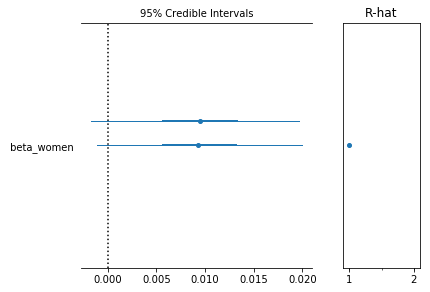

In [121]:
pm.forestplot(trace_B5a, varnames=['beta_women']);
## not significant

In [124]:
## B5b
bangladesh['small'] = bangladesh['living.children'].apply(lambda x: 1 if x <= 2 else 0)
bangladesh.head()

woman  district  use.contraception  living.children  age.centered  urban  \
0      1         1                  0                4       18.4400      1   
1      2         1                  0                1       -5.5599      1   
2      3         1                  0                3        1.4400      1   
3      4         1                  0                4        8.4400      1   
4      5         1                  0                1      -13.5590      1   

   district_id  districtonly  districtmulti  small  
0            0        0.2532         0.2576      0  
1            0        0.2610         0.2760      1  
2            0        0.2572         0.2634      0  
3            0        0.2594         0.2676      0  
4            0        0.2514         0.2784      1

In [125]:
with pm.Model() as small_model:
    alpha = pm.Normal('alpha', 0, 10)
    beta = pm.Normal('beta', 0, 1)
    beta_small = pm.Normal('beta_small', 0, 1)
    
    sd_dist = pm.HalfCauchy.dist(beta=2)
    packed_chol = pm.LKJCholeskyCov('chol_cov', eta=2, n=2, sd_dist=sd_dist)
    
    # compute the covariance matrix
    chol = pm.expand_packed_triangular(2, packed_chol, lower=True)
    cov = T.dot(chol, chol.T)
    
    # Extract the standard deviations and rho
    sigma_ab = pm.Deterministic('sigma', T.sqrt(T.diag(cov)))
    corr = T.diag(sigma_ab**-1).dot(cov.dot(T.diag(sigma_ab**-1)))
    r = pm.Deterministic('Rho', corr[np.triu_indices(2, k=1)])
    
    mu_raw = pm.Normal('mu_raw', mu=0, sd=1, shape=(num_districts, 2))
    mu = T.stack([alpha,beta])+T.dot(chol,mu_raw.T).T
    #vals = pm.Deterministic('vals', tt.dot(chol, vals_raw.T).T)
    
    alpha_district = pm.Deterministic('alpha_district', mu[:, 0])
    beta_district = pm.Deterministic('beta_district', mu[:, 1])
    
    p = pm.math.invlogit(mu[bangladesh.district_id.values, 0] + mu[bangladesh.district_id.values, 1] * bangladesh.urban.values
        + beta_small * bangladesh['small'].values)
    o = pm.Bernoulli('contraception', p=p, observed=bangladesh['use.contraception'])

In [126]:
with small_model:
    trace_B5b = pm.sample(5000, tune = 2000, target_accept = 0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_raw, chol_cov, beta_small, beta, alpha]
Sampling 2 chains: 100%|██████████| 14000/14000 [03:17<00:00, 70.72draws/s] 


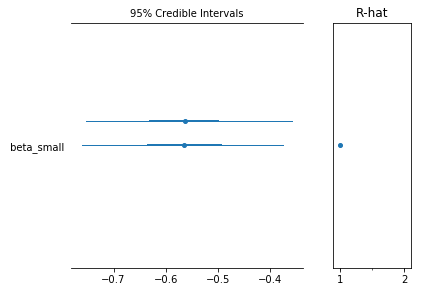

In [127]:
pm.forestplot(trace_B5b, varnames=['beta_small']);
## not significant

In [154]:
## B6
df_compare = pm.compare({districtonly_model: trace_A1, districtmulti_model: trace_A2, correlation_model2: correlation_model_trace2, centeredwomen_model:trace_B5a, small_model:trace_B5b}, method='pseudo-BMA')
# df_compare = pm.compare({districtonly_model: trace_A1})
df_compare['name'] = ['fixed_intercept', 'multi_intercept', 'correlation_slope', 'add_women', 'add_small']
df_compare.set_index('name')

/Users/gwungwun/anaconda/lib/python3.6/site-packages/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


WAIC  pWAIC  dWAIC weight     SE    dSE var_warn
name                                                                  
fixed_intercept    2437.98  54.49      0      1  29.81      0        0
multi_intercept    2467.21  54.29  29.23      0   28.4   9.54        0
correlation_slope  2468.58  52.98   30.6      0  28.19   11.2        0
add_women          2513.97  35.56  75.99      0  25.05   17.5        0
add_small          2533.91  62.89  95.92      0  33.09  21.71        1

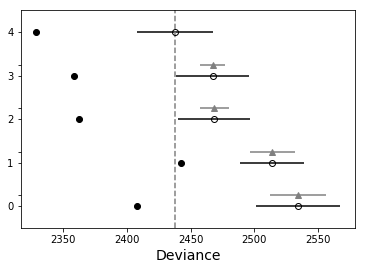

In [156]:
pm.compareplot(df_compare)

In [ ]:
## best model: additional small kid terms

## Q2: Mixture of experts and mixture density networks to solve inverse problems

What if you had to predict a one-to-many function? The data provided below comes from a dataset generated by Chris Bishop (yes that Bishop) to explain the models mentioned in the title above. We have included pdfs from his book which describe these models in some detail. We saw this model earlier in HW where we did an EM like algorithm to obtain a mixture of regressions.

The data is in `one-to-many.csv`

When we plot the data it looks like this. Notice both the uneven sampling (more towards the center), and the "more than one y" for a given x.

![](images/inverse.png)

Normal regression approaches to modeling such a function wont work, as they expect the function to be a proper mathematical function, that is, single valued.

These kind of problems are called **inverse problems**, where more than one input state leads to an output state, and we have to try and model these multiple input states.

A mixture of gaussians (or other distributions) might is a sensible way to do this.

You choose one of the gaussians with some probability. The nean of the gaussian is then given by some regression function, say for example a straight line. We could additionally fix the standard deviation or model it as well. 

Thus, for each component Gaussian, we choose a functional form for the mean and standard deviation. So our model looks something like this:

$$f(x)  = \sum_i \lambda_i g_i (x) $$

Say we fit a model with 3 gaussians to this data. Such a model cannot fit the function above. Notice for example that at $x=0.2$ only one of the gaussians will dominate, different from the situation at $x=0.5$. This means that the probabilities of "belonging" to one or the other gaussians is also changing with $x$.

If we allow the mixing probabilities to depend on $x$, we can model this situation.

$$f(x)  = \sum_i \lambda_i (x) g_i (x) $$

Such a model is called a "mixture of experts" model. The idea is that one "expert" gaussian is responsible in one sector of the feature space, while another expert is responsible in another sector.

You can think of this model as implementing a "standard" gaussian mixture at each "point" x, with the added complexity that all of the means, standard deviations, and mixture probabilities change from one x to another.

See https://www.cs.toronto.edu/~hinton/absps/hme.pdf and http://www.ee.hacettepe.edu.tr/~eyuksel/Publications/2012_TwentyYearsofMixtureofExperts.pdf for more details. I found the latter clearer and easier to understand.

For this entire question you might find diagram code from [here](https://github.com/hardmaru/pytorch_notebooks/blob/master/mixture_density_networks.ipynb) useful. Take with attribution.

We will assume we have **3 gaussians**.

## Part A: Variational Mixture of experts

We'll construct a gaussian mixture model of 3 "expert" linear regressions. The idea is to create a fit which looks like this:

![](images/mixreg.png)

Here the three regression lines work in different regions of $f$. We want a pricipled way to sample from this model and to be able to produce posteriors and posterior-predictives.

There are 3 parts to this model. First the means of the gaussians in the mixture are modeled with linear regression as shown in the picture above. We will also model $log(\sigma)$ for each gaussian in the mixture as a linear regression as well ($\sigma$ needs to be positive).

We now need to model the mixture probabilities, i.e., the probabilities required to choose one or the other gaussian. These mixing probabilities, the $\lambda$s will be modeled as a softmax regression (ie do a linear regression and softmax it to get 3 probabilities).

**A1** Write a pymc3 model for this problem. For all biases and weights in your regressions, assume N(0,5) priors. Add noise 0.01 to each of the three $\sigma$s to make sure you dont have a collapsed 0 width gaussian, ie we want some data in every cluster. (Thus to get the final $\sigma$, you will exponentiate your regression for $log(\sigma)$ and add 0.01.)

**A2** Fit this model variationally for about 50,000 iterations using the adam optimizer. (`obj_optimizer=pm.adam()`) Plot the ELBO to make sure you have converged. Print summaries and traceplots for the means, $\sigma$s and probabilities.

**A3** Plot the mean posteriors with standard deviations against x. Also produce a diagram like the one above to show the mean"s with standard deviations showing their uncertainty overlaid on the data.

**A4** Plot the posterior predictive (mean and variance) as a function of x) for this model (using `sample_ppc` for example). Why does the posterior predictive look nothing like the data?

**A5** Make a "correct" posterior predictive diagram by taking into account which "cluster" or "regression line" the data is coming from. To do this you will need to sample using the softmax probabilities. A nice way to do this is "Gumbel softmax sampling". See http://timvieira.github.io/blog/post/2014/07/31/gumbel-max-trick/ for details. Color-code the predictive samples with the gaussian they came from. Superimpose the predictive on the original data. You may want to contrast a prediction from a point estimate at the mean values of the $\mu$ and $\sigma$ traces at a given x (given the picked gaussian) to the "full" posterior predictive obtained from sampling from the entire trace of $\mu$ and $\sigma$ and $\lambda$. The former diagram may look something like this:

![](images/mixpred.png)

In [157]:
df = pd.read_csv("one-to-many.csv")
print(len(df))
df.head()

1000


target         x
0  0.000000  0.018727
1  0.001001  0.050424
2  0.002002  0.042375
3  0.003003  0.038596
4  0.004004  0.019352

In [175]:
# A1
X_shared = shared(df.x.values.reshape(-1, 1))
num_experts = 3

In [177]:
with pm.Model() as vme:
    alpha_mu = pm.Normal('alpha_mu', 0, 5, shape=(1, num_experts))
    beta_mu = pm.Normal('beta_mu', 0, 5, shape=(1, num_experts))
    mu = pm.Deterministic('mu', alpha_mu + pm.math.dot(X_shared, beta_mu))
    
    alpha_sigma = pm.Normal('alpha_sigma', 0, 5, shape=(1, num_experts))
    beta_sigma = pm.Normal('beta_sigma', 0, 5, shape=(1, num_experts))
    sigma = pm.Deterministic('sigma', pm.math.exp(alpha_sigma + pm.math.dot(X_shared, beta_sigma)) + 0.01)
    
    alpha_w = pm.Normal('alpha_w', 0, 5, shape=(1, num_experts))
    beta_w = pm.Normal('beta_w', 0, 5, shape=(1, num_experts))
    w_temp = alpha_w + pm.math.dot(X_shared, beta_w)
    weight = pm.Deterministic('weight', T.nnet.softmax(w_temp))
    
    o = pm.NormalMixture('obs', weight, mu, sd=sigma, observed=df.target.reshape(-1, 1))

/Users/gwungwun/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:15: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  from ipykernel import kernelapp as app


In [179]:
# A2

with vme:
    inference = pm.ADVI()
    approx_A2 = pm.fit(n=50000, method = inference, obj_optimizer=pm.adam())

Average Loss = -1,601.3: 100%|██████████| 50000/50000 [00:39<00:00, 1267.21it/s]
Finished [100%]: Average Loss = -1,601.3


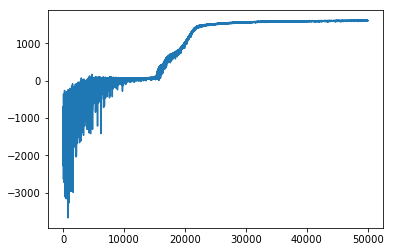

In [180]:
plt.plot(-approx_A2.hist);

In [181]:
trace_vme = approx_A2.sample(5000)

In [183]:
pm.summary(trace_vme, varnames=['alpha_mu', 'beta_mu', 'alpha_sigma', 'beta_sigma', 'alpha_w', 'beta_w'])

mean        sd  mc_error    hpd_2.5   hpd_97.5
alpha_mu__0_0     -0.020558  0.000809  0.000011  -0.022211  -0.019015
alpha_mu__0_1      0.573445  0.000761  0.000010   0.571978   0.574932
alpha_mu__0_2      1.331251  0.002081  0.000032   1.327133   1.335310
beta_mu__0_0       0.425660  0.002337  0.000034   0.421186   0.430312
beta_mu__0_1       0.426226  0.000972  0.000013   0.424379   0.428191
beta_mu__0_2      -1.589743  0.003903  0.000054  -1.597018  -1.581870
alpha_sigma__0_0  -9.952475  0.144666  0.001992 -10.231568  -9.666448
alpha_sigma__0_1   1.622302  0.107620  0.001440   1.422493   1.846557
alpha_sigma__0_2  -4.341157  0.058288  0.000766  -4.455159  -4.228087
beta_sigma__0_0    9.793132  0.287886  0.003867   9.227503  10.356730
beta_sigma__0_1  -11.789848  0.207596  0.003387 -12.202336 -11.396805
beta_sigma__0_2    1.462794  0.108861  0.001539   1.248214   1.666214
alpha_w__0_0       4.382631  0.090643  0.001168   4.205358   4.561690
alpha_w__0_1      -4.783818  0.087244  0.001048  -4.957027  -4.616444
alpha_w__0_2       0.533496  0.068951  0.000900   0.408560   0.676284
beta_w__0_0       -9.403634  0.193327  0.002391  -9.796788  -9.033731
beta_w__0_1        8.338789  0.142706  0.001868   8.056096   8.615891
beta_w__0_2       -0.096861  0.131719  0.001784  -0.360922   0.156677

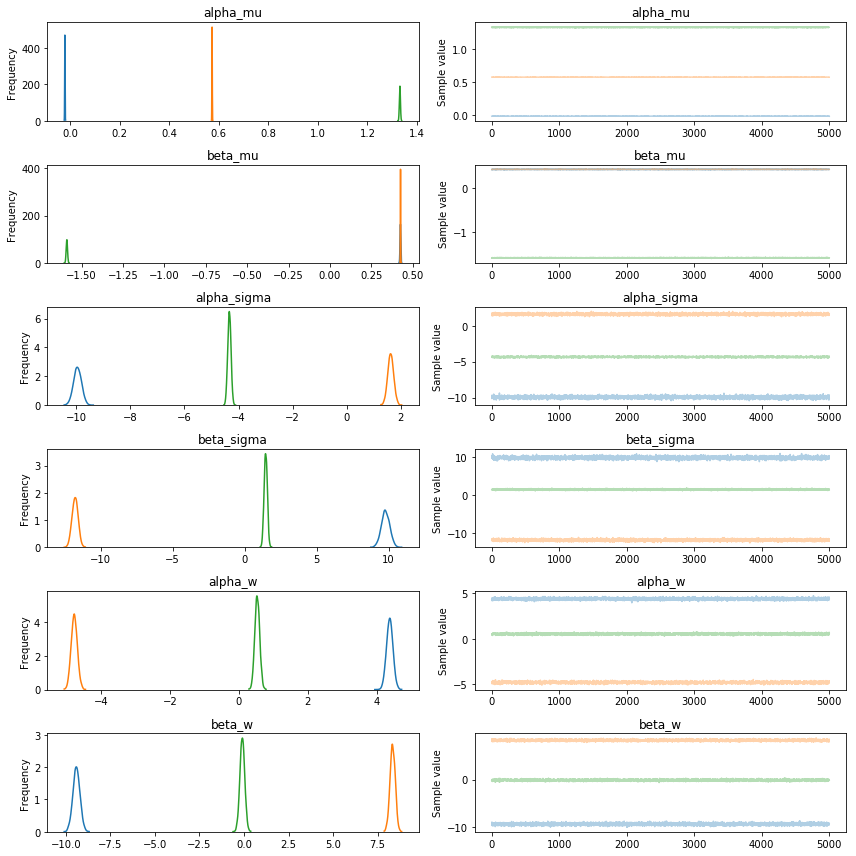

In [185]:
pm.traceplot(trace_vme, varnames=['alpha_mu', 'beta_mu', 'alpha_sigma', 'beta_sigma', 'alpha_w', 'beta_w']);

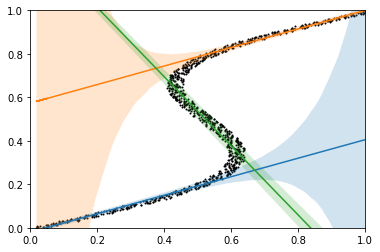

In [200]:
# A3
plt.scatter(df.x.values, df.target.values, color = 'black', s = 1)

for i in range(num_experts):
    mu_t = trace_vme['mu'].mean(axis = 0)[:,i]
    sigma_t = trace_vme['sigma'].mean(axis = 0)[:,i]
    
    plt.plot(df.x.values, mu_t)
    plt.fill_between(df.x.values, mu_t - sigma_t, mu_t + sigma_t, alpha = 0.2)
    
plt.xlim([0, 1]);
plt.ylim([0, 1]);

In [201]:
# A4
with vme:
    ppc_vme = pm.sample_ppc(trace_vme)

100%|██████████| 5000/5000 [06:30<00:00, 14.26it/s]


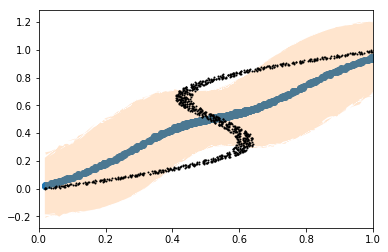

In [211]:
mu_t = ppc_vme['obs'].mean(axis = 0)
sigma_t = ppc_vme['obs'].std(axis = 0)

plt.scatter(df.x.values, mu_t)
plt.fill_between(df.x.values, mu_t-sigma_t, mu_t+sigma_t, alpha=0.2)
plt.scatter(df.x.values, df.target.values, color = 'black', s =1);

plt.xlim([0, 1]);

weighted by all 3 models, but indeed we just sample from 1 expert

Color-code the predictive samples with the gaussian they came from. Superimpose the predictive on the original data. You may want to contrast a prediction from a point estimate at the mean values of the  μμ  and  σσ  traces at a given x (given the picked gaussian) to the "full" posterior predictive obtained from sampling from the entire trace of  μμ  and  σσ  and  λλ . The former diagram may look something like this:

In [212]:
# A5
def gumbel_max_sample(x):
    z = np.random.gumbel(loc=0, scale=1, size=x.shape)
    return (np.log(x) + z).argmax(axis=1)

In [216]:
k = gumbel_max_sample(trace_vme['weight'].mean(axis = 0))

In [223]:
indices = (np.arange(len(df)), k)
rvs = np.random.randn(len(df))
ppc = rvs * trace_vme['sigma'].mean(axis = 0)[indices] + trace_vme['mu'].mean(axis = 0)[indices]

(0, 1)

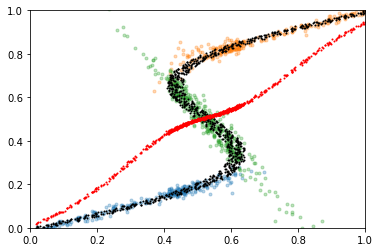

In [230]:
for i in range(3):
    plt.scatter(df.x.values[i == k], ppc[i == k], alpha=0.3, marker='.');
plt.scatter(df.x.values, df.target.values, color = 'black', s = 1);
plt.scatter(df.x.values, mu_t, color = 'red', s = 1);
plt.xlim((0,1))
plt.ylim((0,1))

## Part B. Mixture Density Network

A mixture density network (see the enclosed Chapter 5 excerpt from Bishop or https://publications.aston.ac.uk/373/1/NCRG_94_004.pdf) is very closely related to the mixture of experts model. The difference is that we fit the regressions using a neural network where hidden layers are shared amongst the mean, sigma, and mixing probability regressions. (We could have fit 3 separate neural networks in Part A but opted to fit linear regressions for simplicity)

(More explanation [here](https://github.com/hardmaru/pytorch_notebooks/blob/master/mixture_density_networks.ipynb). You are welcome to take code from here with attribution.)

You job here is to construct a multi-layer perceptron model with a linear hidden layer with 20 units followed by a `Tanh` activation. After the activation layer, 3 separate linear layers with `n_hidden` inputs and `n_gaussian=3` outputs will complete the network. The probabilities part of the network is then passed through a softmax. The means part is left as is. The sigma part is exponentiated and 0.01 added, as in part A

Thus the structure looks like:

```
input:1 --linear-> n_hidden -> Tanh --linear-->n_gaussians      ...mu
                            --linear-->n_gaussians->softmax     ...lambda
                            --linear-->n_gaussians->exp + 0.01  ...sigma
```

We then need to use a loss function for the last layer of the network. 

Using the mean-squared-error loss is not appropriate as the expected value of samples drawn from the sampling distribution of the network will not reflect the 3-gaussian structure (this is the essence of the difference between A4 and A5 above). Thus we'll use the negative loss likelihood of the gaussian mixture model explicitly.

**B1**: Write the network as a class `MixtureDensityNetwork` which inherits from pytorch `nn.Module`. Implement a constructor which allows at-least the number of hidden layers to be varied. Also implement the `forward` method.

**B2**: Train the network using the Adam or similiar optimizer and gradient descent/SGD. Make sure your loss converges and plot this convergence.

**B3**: Plot the MLE parameters against x. Make a plot similar to A3 above where you overlay the "means" of the gaussians against the data.  Plot traces of the mu/sigma/lambda as an aid in debugging.

**B4**: Sample from the sampling distributions at the estimated point values of $\mu$ and $\sigma$ (given cluster) to make a plot similar to A5 above

**To think but not to hand in** What are the differences between a mixture density network and the mixture of experts. How do these differences translate to feature space? What would happen if we took the shared hidden layer nonlinearity (Tanh) out?

In [235]:
# B1 (attributed to link above)

class MixtureDensityNetwork(nn.Module):
    def __init__(self, n_hidden, n_gaussians):
        super(MixtureDensityNetwork, self).__init__()
        self.z_h = nn.Sequential(
            nn.Linear(1, n_hidden),
            nn.Tanh()
        )
        self.z_pi = nn.Linear(n_hidden, n_gaussians)
        self.z_sigma = nn.Linear(n_hidden, n_gaussians)
        self.z_mu = nn.Linear(n_hidden, n_gaussians)  

    def forward(self, x):
        z_h = self.z_h(x)
        pi = nn.functional.softmax(self.z_pi(z_h), -1)
        sigma = torch.exp(self.z_sigma(z_h))
        mu = self.z_mu(z_h)
        return pi, sigma, mu
    
oneDivSqrtTwoPI = 1.0 / np.sqrt(2.0*np.pi) # normalization factor for Gaussians
def gaussian_distribution(y, mu, sigma):
    # make |mu|=K copies of y, subtract mu, divide by sigma
    result = (y.expand_as(mu) - mu) * torch.reciprocal(sigma)
    result = -0.5 * (result * result)
    return (torch.exp(result) * torch.reciprocal(sigma)) * oneDivSqrtTwoPI

def mdn_loss_fn(pi, sigma, mu, y):
    result = gaussian_distribution(y, mu, sigma) * pi
    result = torch.sum(result, dim=1)
    result = -torch.log(result)
    return torch.mean(result)

In [248]:
# B2

mdn = MixtureDensityNetwork(n_hidden=20, n_gaussians=num_experts)
optimizer = torch.optim.Adam(mdn.parameters())

x_tensor = torch.from_numpy(np.float32(df.x.values).reshape(-1, 1))
y_tensor = torch.from_numpy(np.float32(df.target.values).reshape(-1, 1))
x_variable = Variable(x_tensor)
y_variable = Variable(y_tensor, requires_grad=False)

In [249]:
def train_mdn(epochs = 10000):
    loss_ls = []
    for epoch in range(epochs):
        pi_variable, sigma_variable, mu_variable = mdn(x_variable)
        loss = mdn_loss_fn(pi_variable, sigma_variable, mu_variable, y_variable)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_ls.append(loss.data[0])
        
        if epoch % 1000 == 0:
            print(epoch, loss.data[0])
    
    return loss_ls

In [250]:
epochs = 20000
loss_ls = train_mdn(epochs)

/Users/gwungwun/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  if __name__ == '__main__':
/Users/gwungwun/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  if sys.path[0] == '':


0 tensor(1.2957)
1000 tensor(-0.1268)
2000 tensor(-1.9340)
3000 tensor(-1.9676)
4000 tensor(-1.9807)
5000 tensor(-1.9991)
6000 tensor(-2.0268)
7000 tensor(-2.0568)
8000 tensor(-2.0758)
9000 tensor(-2.0790)
10000 tensor(-2.0928)
11000 tensor(-2.0981)
12000 tensor(-2.1014)
13000 tensor(-2.1058)
14000 tensor(-2.1029)
15000 tensor(-2.1122)
16000 tensor(-2.1151)
17000 tensor(-2.1175)
18000 tensor(-2.1169)
19000 tensor(-2.1242)


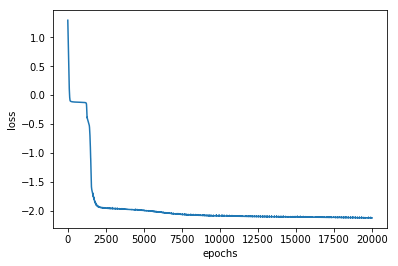

In [251]:
plt.plot(np.arange(epochs), loss_ls);
plt.xlabel('epochs');
plt.ylabel('loss');

In [289]:
# B3
pi_variable, sigma_variable, mu_variable = mdn(x_variable)

In [290]:
pi_data, sigma_data, mu_data = pi_variable.data.numpy(), sigma_variable.data.numpy(), mu_variable.data.numpy()

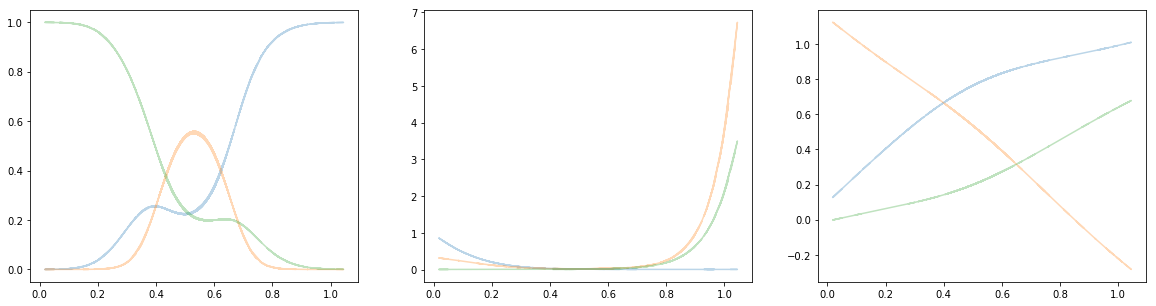

In [292]:
fig, ax = plt.subplots(1, 3, sharex=True, figsize=(20, 5))
for i, data in enumerate([pi_data, sigma_data, mu_data]):
    ax[i].plot(df.x.values, data, alpha=0.3)

(0, 1)

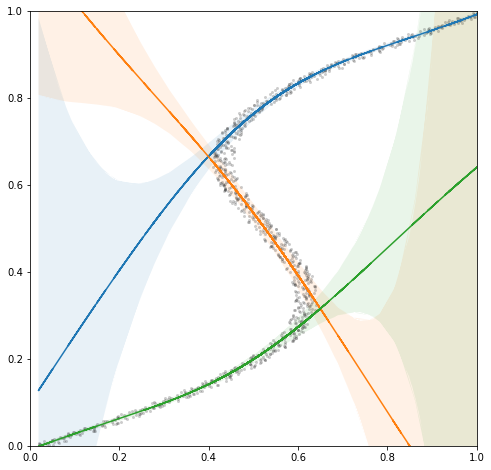

In [293]:
plt.figure(figsize=(8, 8), facecolor='white')
for mu_k, sigma_k in zip(mu_data.T, sigma_data.T):
    plt.plot(df.x.values, mu_k)
    plt.fill_between(df.x.values, mu_k-sigma_k, mu_k+sigma_k, alpha=0.1)
plt.scatter(df.x.values, df.target.values, marker='.', lw=0, alpha=0.2, c='black')
plt.xlim([0,1])
plt.ylim([0,1])

In [294]:
# B4
def gumbel_sample(x, axis=1):
    z = np.random.gumbel(loc=0, scale=1, size=x.shape)
    return (np.log(x) + z).argmax(axis=axis)

k = gumbel_sample(pi_data)

indices = (np.arange(len(df)), k)
rn = np.random.randn(len(df))
sampled = rn * sigma_data[indices] + mu_data[indices]

(0, 1)

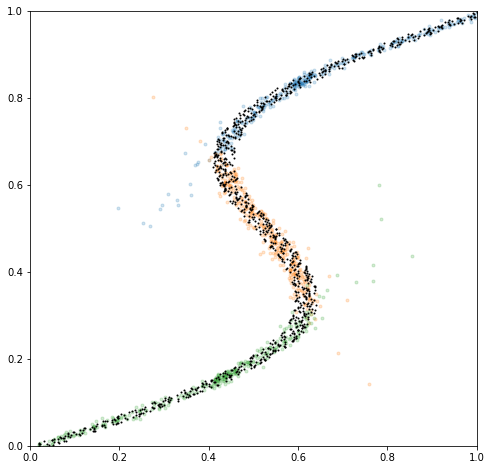

In [295]:
plt.figure(figsize=(8, 8))

for i in range(3):
    plt.scatter(df.x.values[k==i], sampled[k==i], alpha=0.2, marker='.');
    
plt.scatter(df.x.values, df.target.values, color = 'black', s = 1);
plt.xlim(0,1)
plt.ylim(0,1)

## Part C Variational Mixture Density Network

We want to implement the Mixture Density Metwork model that we constructed in Part B  directly in pymc3 and use variational inference to sample from it. We  may need more iterations in order to get convergence as this model will likely not converge as fast as the pytorch equivalent.

**C1**: Write out the equivalent pymc3 version of the MDN and generate posterior samples with ADVI.

**C2**: Sample from the posterior predictive and produce a diagram like B4 and A5 for this model. Plot traces of the mu/sigma/lambda as an aid in debugging your sampler.

**C3**: Plot the "mean" regression curves (similar to B3 and A3). Do the "mean" regression curves in this model look the same from those in Part B?  If they differ why so?

In [333]:
# C1
def construct_mdn(ann_in, ann_out, n_hidden=20, n_gaussians=num_experts):
    with pm.Model() as vmdn:
        # linear
        w_in_1 = pm.Normal('w_in_1', 0, sd=1, shape=(1, n_hidden))
        b_in_1 = pm.Normal('b_h', 0, sd=1, shape=(1, n_hidden))
        
        #tanh
        tanh = pm.math.tanh(b_in_1 + pm.math.dot(ann_in, w_in_1))
        
        #mean
        w_mean = pm.Normal('w_mean', 0, sd=1, shape=(n_hidden, n_gaussians))
        b_mean = pm.Normal('b_mean', 0, sd=1, shape=(1, n_gaussians))
        mean = pm.Deterministic('mean', b_mean + pm.math.dot(tanh, w_mean))
        
        #std
        w_std = pm.Normal('w_std', 0, sd=1, shape=(n_hidden, n_gaussians))
        b_std = pm.Normal('b_std', 0, sd=1, shape=(1, n_gaussians))
        std = pm.Deterministic('std', pm.math.exp(b_std + pm.math.dot(tanh, w_std)) + 0.01)
        
        #lambda
        w_lambda = pm.Normal('w_lambda', 0, sd=1, shape=(n_hidden, n_gaussians))
        b_lambda = pm.Normal('b_lambda', 0, sd=1, shape=(1, n_gaussians))
        lamda = pm.Deterministic('lamda', T.nnet.softmax(b_lambda + pm.math.dot(tanh, w_lambda)))
        
        o = pm.NormalMixture('obs', lamda, mean, sd=std, observed=ann_out)
        
    return vmdn

In [334]:
vmdn = construct_mdn(df.x.values.reshape(-1, 1), df.target.values.reshape(-1, 1))

with vmdn:
    inference = pm.ADVI()
    approx_C2 = pm.fit(n=100000, method = inference, obj_optimizer=pm.adam())

Average Loss = -1,458.4: 100%|██████████| 100000/100000 [01:52<00:00, 891.38it/s]
Finished [100%]: Average Loss = -1,458.6


(-10000, 2000)

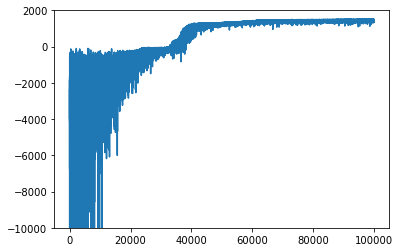

In [335]:
plt.plot(-approx_C2.hist);
plt.ylim(-10000, 2000)

In [336]:
# C2
#trace
trace_C2 = approx_C2.sample(5000)

In [337]:
##pp
with vmdn:
    ppc_vmdn = pm.sample_ppc(trace_C2)

100%|██████████| 5000/5000 [06:04<00:00, 13.71it/s]


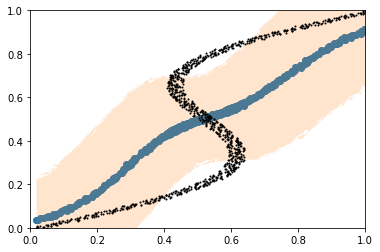

In [338]:
mu_t = ppc_vmdn['obs'].mean(axis = 0)
sigma_t = ppc_vmdn['obs'].std(axis = 0)

plt.scatter(df.x.values, mu_t)
plt.fill_between(df.x.values, mu_t-sigma_t, mu_t+sigma_t, alpha=0.2)
plt.scatter(df.x.values, df.target.values, color = 'black', s =1);

plt.xlim(0, 1);
plt.ylim(0, 1);

In [339]:
# gumbel
mu_t = trace_C2['mean'].mean(axis=0)
sigma_t = trace_C2['std'].mean(axis=0)

k = gumbel_sample(trace_C2['lamda'].mean(axis=0))

indices = (np.arange(len(df)), k)
rn = np.random.randn(len(df))
sampled = rn * sigma_t[indices] + mu_t[indices]

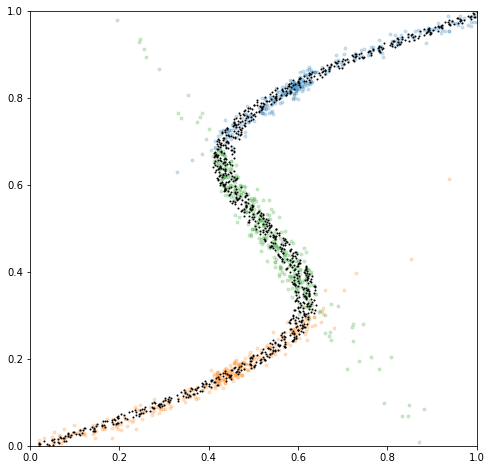

In [340]:
plt.figure(figsize=(8, 8))

for i in range(3):
    plt.scatter(df.x.values[k==i], sampled[k==i], alpha=0.2, marker='.');

plt.scatter(df.x.values, df.target.values, color='black', s= 1);
plt.xlim(0, 1);
plt.ylim(0, 1);

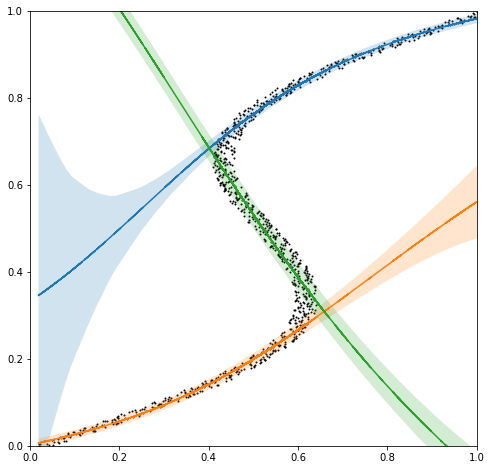

In [341]:
## C3
plt.figure(figsize=(8, 8), facecolor='white')
plt.scatter(df.x.values, df.target.values, color = 'black', s = 1)

for i in range(num_experts):
    mu_t = trace_C2['mean'].mean(axis = 0)[:,i]
    sigma_t = trace_C2['std'].mean(axis = 0)[:,i]
    
    plt.plot(df.x.values, mu_t)
    plt.fill_between(df.x.values, mu_t - sigma_t, mu_t + sigma_t, alpha = 0.2)
    
plt.xlim(0, 1);
plt.ylim(0, 1);

In [ ]:
# normal prior : regularization
# nn: maximum likelihood vs vb: less overfitting

## Q3:  Exploring Temperature in Sampling and Optimiztion

At various times in class we've discussed in very vague terms the relation between "temperature" and sampling from or finding optima of distributions.  Promises would invariably be made that at some later point we'd discuss the concept of temperature and sampling/optima finding in more detail.  Let's take this problem as an opportunity to keep our promise.

Let's start by considering the function $f(x, y)$ defined in the following code cell. $f(x, y)$ is a mixture of three well separated Gaussian probability densities.

In [2]:
make_cov = lambda  theta: np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])

theta_vec = (5.847707364986893, 5.696776968254305, 1.908095937315489)
theta1, theta2, theta3 = theta_vec

# define gaussian mixture 1 
cov1 = make_cov(theta1)
sigma1 = np.array([[2, 0],[0, 1]])
mvn1 = scipy.stats.multivariate_normal([12, 7], cov=cov1@sigma1@cov1.T)

# define gaussian mixture 2
cov2 = make_cov(theta2)
sigma2 = np.array([[1, 0],[0, 3]])
mvn2 = scipy.stats.multivariate_normal([-1, 6], cov=cov2@sigma2@cov2.T)

cov3 = make_cov(theta3)
sigma3 = np.array([[.4, 0],[0, 1.3]])
mvn3 = scipy.stats.multivariate_normal([3,-2], cov=cov3@sigma3@cov3.T)

mu1 = [12, 7]
mu2 = [-1, 6]
mu3 = [3, -2]

f = lambda xvec: mvn1.pdf(xvec) + mvn2.pdf(xvec) + .5*mvn3.pdf(xvec)

p = lambda x, y: f([x,y])

## Part A Visualization and Metropolis

**A1**. Visualize $p(x, y)$ with a contour or surface plot.  Make sure to title your plot and label all axes.  What do you notice about $p(x, y)$?  Do you think it will be an easy function to sample?

**A2**. Generate 20000 samples from $p(x, y)$ using the Metropolis algorithm.  Pick individual gaussian proposals in $x$ and $y$ with $\sigma=1$, initial values, burnin parameters, and thinning parameter.  Plot traceplots of the $x$ and $y$ marginals as well as autocorrelation plots.  Plot a pathplot of your samples.  Based on your visualizations, has your Metropolis sampler generated an appropriate representation of the distribution $p(x, y)$?

A pathplot is just your samples trace overlaid on your pdf, so that you can see how the sampler traversed. It looks something like this:

![](images/pathplot.png)

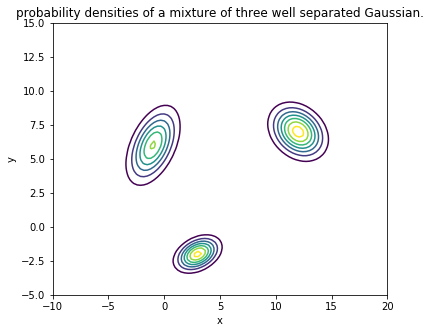

In [3]:
# A1
x_lin = np.linspace(-10, 20, 100)
y_lin = np.linspace(-5, 15, 100)
x_grid, y_grid = np.meshgrid(x_lin, y_lin)
z = np.empty([100, 100])
for i, y in enumerate(y_lin):
    for j, x in enumerate(x_lin):
        z[i, j] = p(x, y)

# contour plot
plt.subplots(figsize=(6, 5));
plt.contour(x_grid, y_grid, z);
plt.xlabel('x')
plt.ylabel('y')
plt.title('probability densities of a mixture of three well separated Gaussian.');

In [4]:
# A2
from scipy.stats import multivariate_normal
def metropolis(p, q_draw, m, c, N, start, burnin=0.1, thin=2):
    samples = np.empty((N, 2))
    x_prev = start
    accepted = np.zeros((N,))
    
    for i in range(N):
        x_star = q_draw(x_prev, m, c)
        p_star = p(x_star[0], x_star[1])
        p_prev = p(x_prev[0], x_prev[1])
        pdf_ratio = p_star / p_prev
        if np.random.uniform() < min(1, pdf_ratio):
            samples[i, :] = x_star
            x_prev = x_star
            accepted[i] = 1
        else:
            samples[i, :] = x_prev
        if i % 100 == 0:
            print('i = {}'.format(i), end='\r')
            
    # throw away burnin and thin
    samples = samples[int(burnin*N)::thin]
    accepted_count = np.sum(accepted[int(burnin*N)::thin])
            
    return samples, accepted_count/len(samples)

def q_draw(current, m, c): 
    return multivariate_normal.rvs(mean=current+m, cov=c)

In [5]:
m = np.array([0, 0])
c = np.array([[1, 0], [0, 1]])
target_N = 20000
burnin = 0.1
thin = 2
N = int((target_N * thin) / (1 - burnin))

samples_Q3_A2, accp_A2 = metropolis(p, q_draw, m, c, N, [0, 0], burnin=burnin, thin=thin)
print('acceptance rate = {}'.format(accp_A2))
print('======================')

acceptance rate = 0.62725


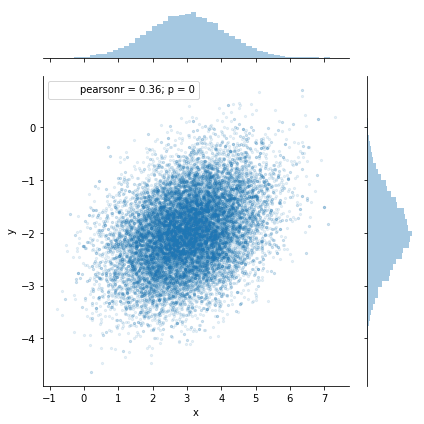

In [24]:
sns.jointplot('x', 'y', pd.DataFrame(samples_Q3_A2, columns=['x', 'y']), cmap='Blues', alpha=0.1, s=5)
plt.tight_layout()

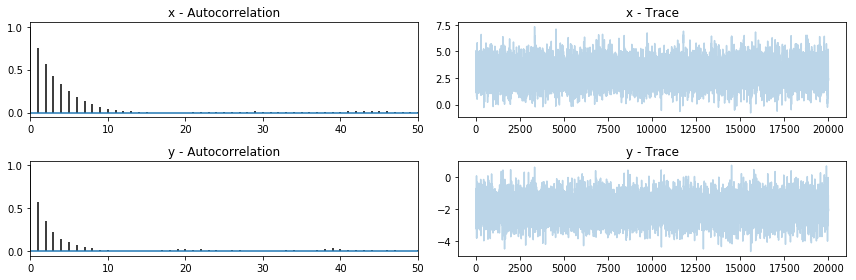

In [25]:
 def plot_autocorr_trace(samples, var_names, maxlags=50):
    fig, ax = plt.subplots(2,2, figsize=(12, 4))
    trace_X1 = samples[:, 0]
    trace_X2 = samples[:, 1]
    
    ax[0,0].acorr(trace_X1 - np.mean(trace_X1), normed=True, maxlags=maxlags);
    ax[0,0].set_xlim([0, maxlags])
    ax[0,0].set_title('{} - Autocorrelation'.format(var_names[0]))
    ax[0,1].plot(trace_X1, alpha=0.3)
    ax[0,1].set_title('{} - Trace'.format(var_names[0]))
    
    ax[1,0].acorr(trace_X2 - np.mean(trace_X2), normed=True, maxlags=maxlags);
    ax[1,0].set_xlim([0, maxlags])
    ax[1,0].set_title('{} - Autocorrelation'.format(var_names[1]))
    ax[1,1].plot(trace_X2, alpha=0.3)
    ax[1,1].set_title('{} - Trace'.format(var_names[1]))
    plt.tight_layout()

plot_autocorr_trace(samples_Q3_A2, ['x', 'y'])

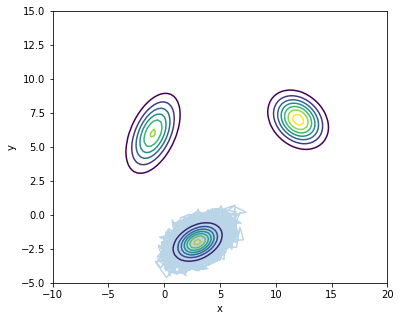

In [28]:
plt.subplots(figsize=(6, 5));
plt.contour(x_grid, y_grid, z);
plt.plot(samples_Q3_A2[:, 0], samples_Q3_A2[:, 1], alpha = 0.3)
plt.xlabel('x')
plt.ylabel('y')

In [ ]:
# converge to one cluster, cov too small

## Part B: Changing pdfs using temperature

Given a function $p(x)$ we can rewrite that function in following way:

$$p(x) = e^{-(-\log(p(x))}$$

So if define the energy density for a function as $E(x)\equiv-\log{p(x)}$

We can now aim to sample from the function parameratized by a Temperature $T$.

$$p(x\vert T) = e^{-\frac{1}{T} E(x)} = p(x)^{\frac{1}{T}}$$

If we set T=1 we're sampling from our original function $p(x)$. 

**B1** In line with A1, visualize modified pdfs (dont worry about normalization) by setting the temperatures to $T=10$ and $T=0.1$. 

**B2**. Modify your Metropolis algorithm above to take a temperature parameter `T` as well as to keep track of the number of rejected proposals.  Generate 20000 samples from $p(x, y)$ at for each of the following temperatures: {0.1, 1, 3, 7, 10}. Construct  histograms of the marginals, traceplots, autocorrelation plots, and a pathplot for your samples at each temperature.  What happens to the number of rejections as temperature increases? In the limits $T \rightarrow 0$ and $T \rightarrow \infty$ what do you think your samplers will do?

**B3**. Approximate the $f(X)$ by the appropriate mixture of Gaussians as a way of generating samples from $f(X)$ to compare with other sampling methods.  Use scipy.stats.multivariate_normal to generate 20000 samples.  How do the histograms compare with the histograms for the samples from $f(X)$ at each temperature.  At what temperature do the samples best represent the function? 

In [6]:
## B1
def p(x, y, T = 1):
    return f([x,y]) ** (1/T)

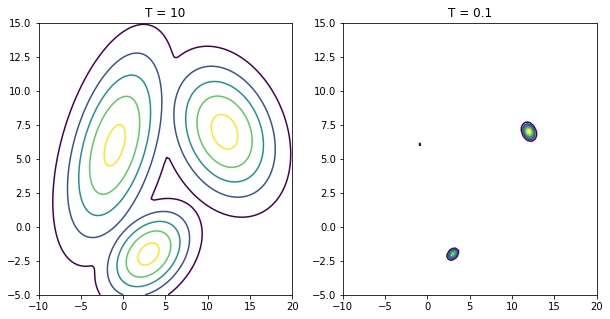

In [29]:
fig, ax = plt.subplots(1, 2, sharex=True, figsize=(10, 5))

for idx, T in enumerate([10, 0.1]):
    z_temp = np.empty([100, 100])
    for i, y in enumerate(y_lin):
        for j, x in enumerate(x_lin):
            z_temp[i, j] = p(x, y, T)
            
    ax[idx].contour(x_grid, y_grid, z_temp);
    ax[idx].set_title("T = {}".format(T))

In [30]:
# B2
def metropolis(p, q_draw, m, c, N, start, T = 1, burnin=0.1, thin=2):
    samples = np.empty((N, 2))
    x_prev = start
    accepted = np.zeros((N,))
    
    for i in range(N):
        x_star = q_draw(x_prev, m, c)
        p_star = p(x_star[0], x_star[1], T)
        p_prev = p(x_prev[0], x_prev[1], T)
        pdf_ratio = p_star / p_prev
        if np.random.uniform() < min(1, pdf_ratio):
            samples[i, :] = x_star
            x_prev = x_star
            accepted[i] = 1
        else:
            samples[i, :] = x_prev
        if i % 100 == 0:
            print('i = {}'.format(i), end='\r')
            
    # throw away burnin and thin
    samples = samples[int(burnin*N)::thin]
    accepted_count = np.sum(accepted[int(burnin*N)::thin])
            
    return samples, accepted_count/len(samples)

In [32]:
samples_Q3_B2_arr = []
acceptance_arr = []

T_ls = [0.1, 1, 3, 7, 10]

for T in T_ls:
    print('T = {}'.format(T))
    samples_Q3_B2, acceptance = metropolis(p, q_draw, m, c, N, [0, 0], T = T, burnin=burnin, thin=thin)
    samples_Q3_B2_arr.append(samples_Q3_B2)
    acceptance_arr.append(acceptance)
    print('acceptance rate = {}'.format(acceptance))
    print('======================')

T = 0.1
acceptance rate = 0.1196
T = 1
acceptance rate = 0.537
T = 3
acceptance rate = 0.7494
T = 7
acceptance rate = 0.8427
T = 10
acceptance rate = 0.874


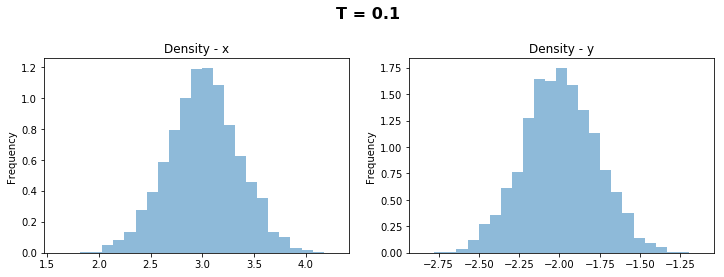

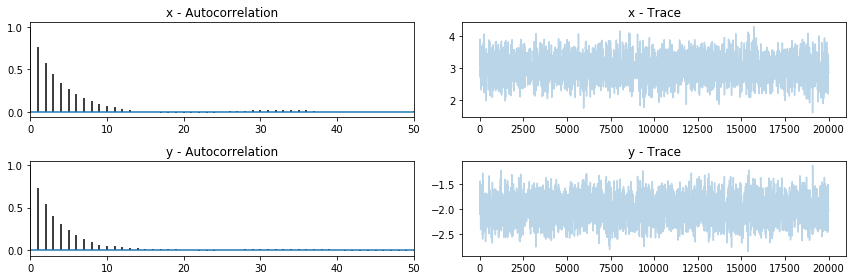

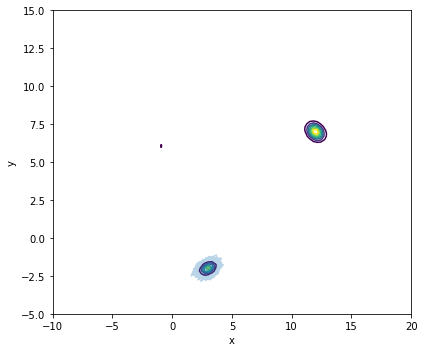

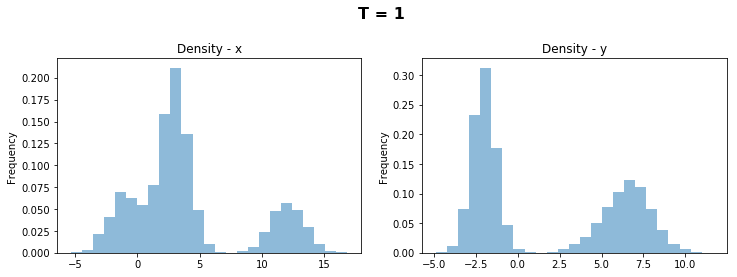

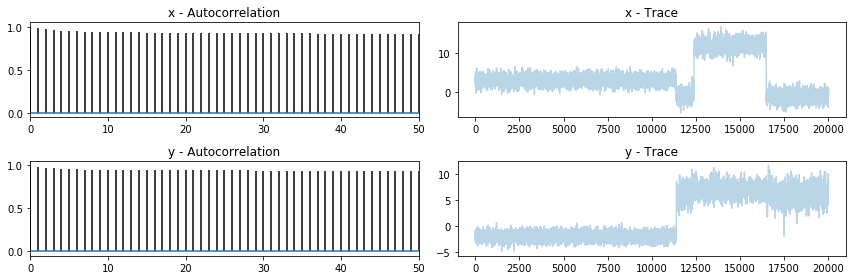

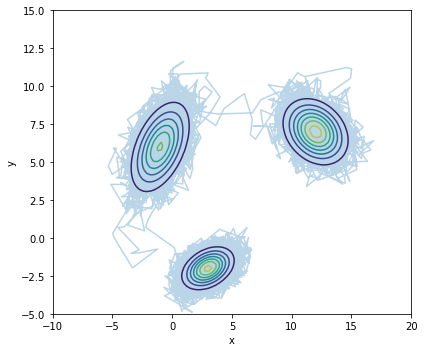

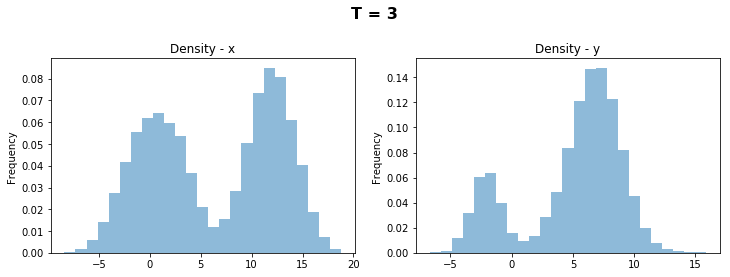

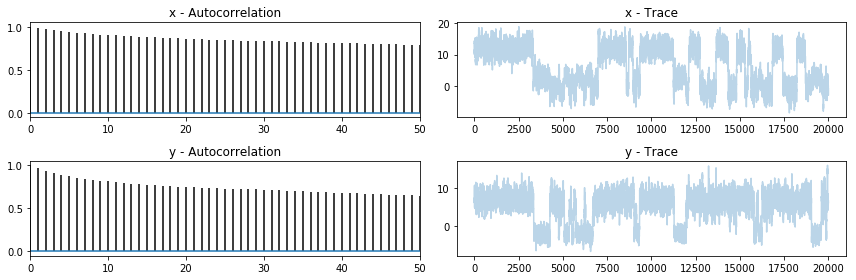

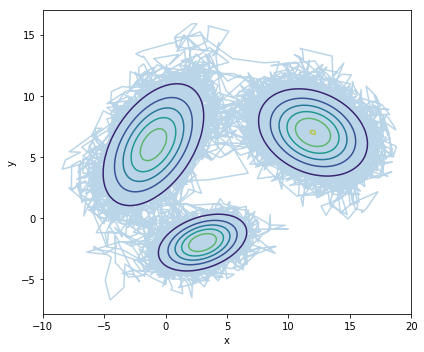

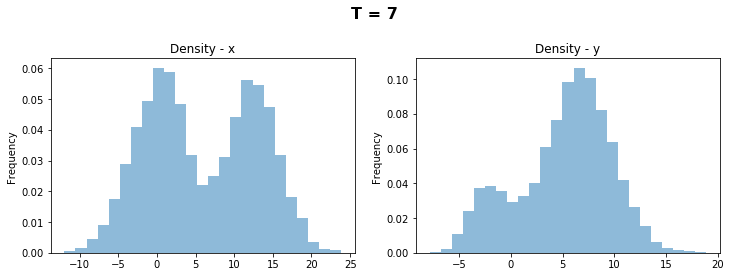

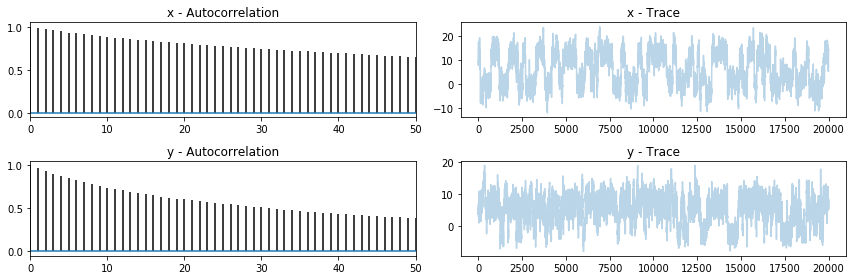

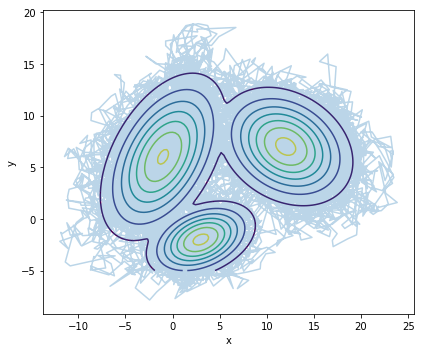

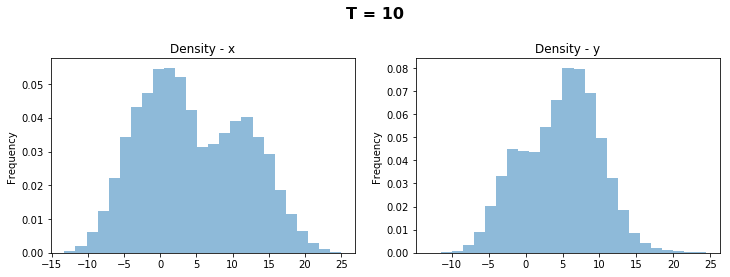

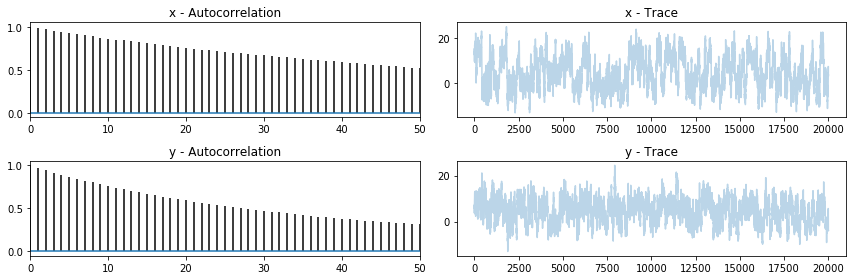

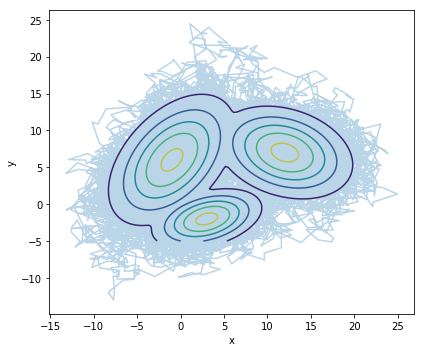

In [37]:
for idx, T in enumerate(T_ls):
    # plotting title
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    plt.suptitle('T = {}'.format(T), fontsize=16, weight='heavy')
    plt.subplots_adjust(top=0.8)
    
    # x, y marginal densities
    pd.Series(samples_Q3_B2_arr[idx][:, 0]).plot(kind='hist', normed=True, alpha=0.5, bins=25, ax=ax[0], title='Density - x')
    pd.Series(samples_Q3_B2_arr[idx][:, 1]).plot(kind='hist', normed=True, alpha=0.5, bins=25, ax=ax[1], title='Density - y')
    
    # autocorrelation & trace plots
    plot_autocorr_trace(samples_Q3_B2_arr[idx], ['x', 'y'])
    
    # path plot
    plt.subplots(figsize=(6, 5));
    z = np.empty([100, 100])
    for i, y in enumerate(y_lin):
        for j, x in enumerate(x_lin):
            z[i, j] = p(x, y, T)
            
    plt.contour(x_grid, y_grid, z);
    plt.plot(samples_Q3_B2_arr[idx][:, 0], samples_Q3_B2_arr[idx][:, 1], alpha = 0.3)
    plt.xlabel('x')
    plt.ylabel('y')
    
    plt.tight_layout()

0: stay infinity: random walk

In [62]:
# B3
def sample_mixture(T = 1, n = 20000):
    samples = np.empty([n, 2])
    for i in range(n):
        k = np.random.choice([0, 1, 2], p = [0.4, 0.4, 0.2])

        if k == 0:
            s= multivariate_normal.rvs(mu1, T*cov1@sigma1@cov1.T)
        elif k == 1:
            s= multivariate_normal.rvs(mu2, T*cov2@sigma2@cov2.T)
        else:
            s= multivariate_normal.rvs(mu3, T*cov3@sigma3@cov3.T)
        
        samples[i,:] = s
        
    return samples

In [63]:
samples_Q3_B3_arr = []
for idx, T in enumerate(T_ls):
    samples_Q3_B3 = sample_mixture(T = T)
    samples_Q3_B3_arr.append(samples_Q3_B3)

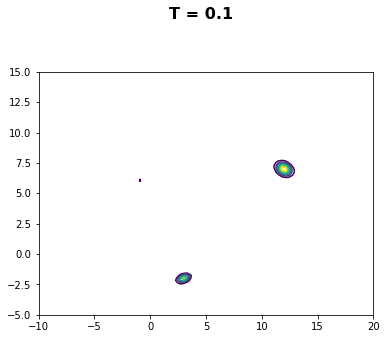

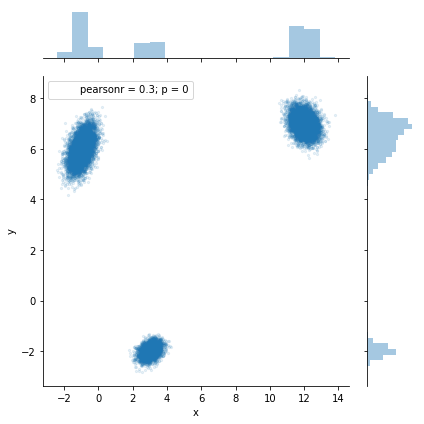

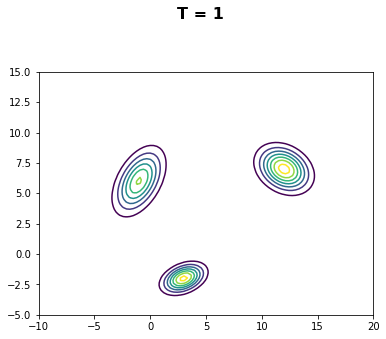

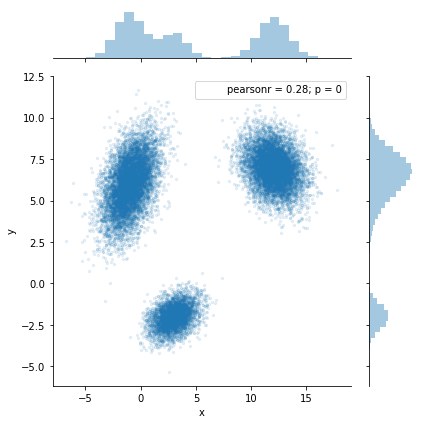

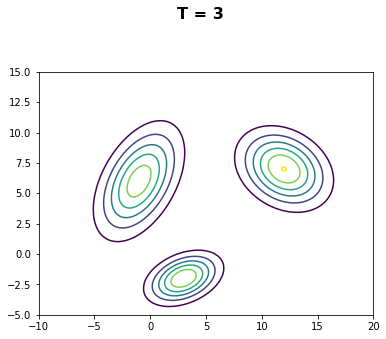

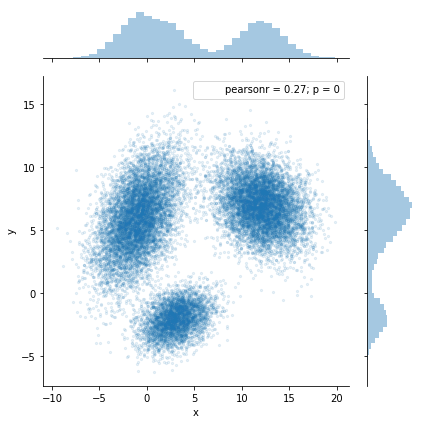

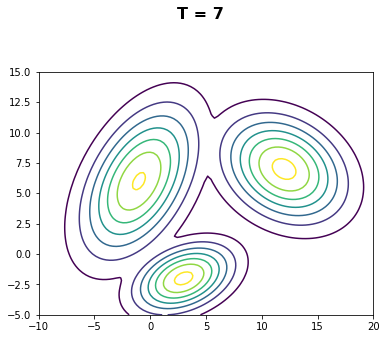

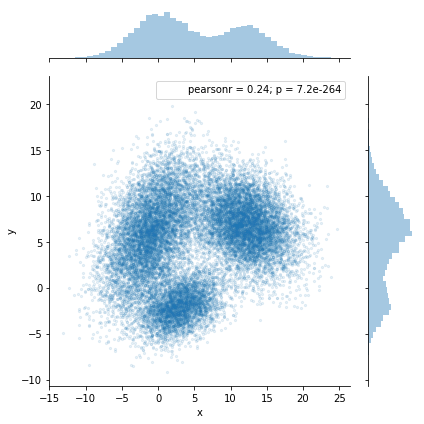

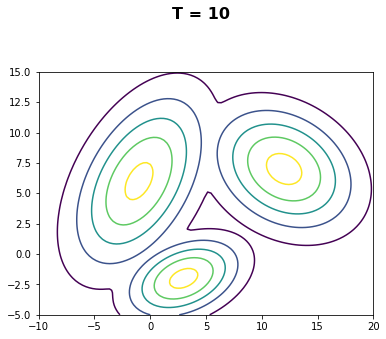

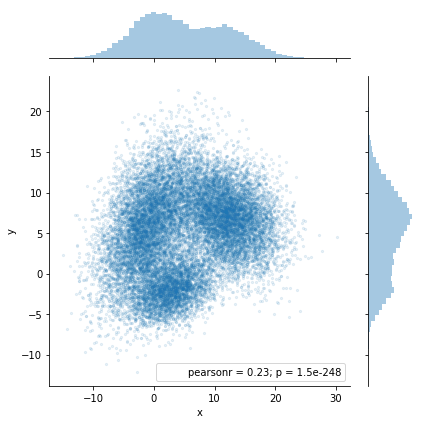

In [72]:
for idx, T in enumerate(T_ls):
    # plotting title
    plt.subplots(figsize=(6, 5));
    plt.suptitle('T = {}'.format(T), fontsize=16, weight='heavy')
    plt.subplots_adjust(top=0.8)
    
    z = np.empty([100, 100])
    for i, y in enumerate(y_lin):
        for j, x in enumerate(x_lin):
            z[i, j] = p(x, y, T)
            
    plt.contour(x_grid, y_grid, z);
    
    sns.jointplot('x', 'y', pd.DataFrame(samples_Q3_B3_arr[idx], columns=['x', 'y']), cmap='Blues', alpha=0.1, s=5)
    plt.tight_layout()

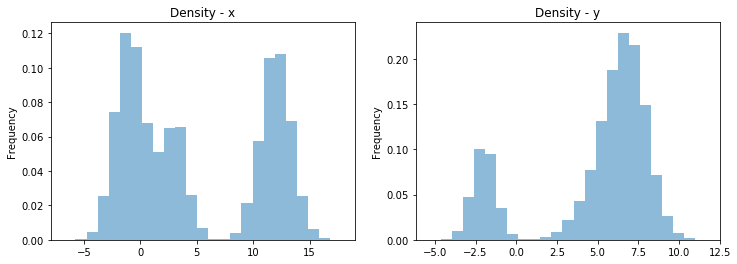

In [378]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
pd.Series(samples_Q3_B3_arr[1][:, 0]).plot(kind='hist', normed=True, alpha=0.5, bins=25, ax=ax[0], title='Density - x')
pd.Series(samples_Q3_B3_arr[1][:, 1]).plot(kind='hist', normed=True, alpha=0.5, bins=25, ax=ax[1], title='Density - y')

In [70]:
## T 3

## Part C: Parallel Tempering

Now that we've seen some of the pproperties of sampling at higher temperatures, let's explore a way to incorporate the improved exploration of the *entire pdf* from sampling at higher temperatures while still getting samples that match our distribution.  We'll use a technique called *parallel tempering*.  

The general idea of parallel tempering is to simulate $N$ replicas of the original system of interest (in our case, a single Metropolis Hastings chain), each replica at a different temperature. The temperature of a Metropolis Hastings Markov Chain defines how likely it is to sample from a low-density part of the target distribution. The high temperature systems are generally able to sample large volumes of parameter space, whereas low temperature systems, while having precise sampling in a local region of parameter space, may become trapped around local energy minima/probability maxima. Parallel tempering achieves good sampling by allowing the chains at different temperatures to exchange complete configurations. Thus, the inclusion of higher temperature chains ensures that the lower temperature chains can access *all* the low-temperature regions of phase space: the higher temperatures help these chains make the jump-over.

Darren Wilkinson's blog post has a [good description](https://darrenjw.wordpress.com/2013/09/29/parallel-tempering-and-metropolis-coupled-mcmc/) of whats going on.

Here is the idea that you must implement.

There are $N$ replicas each at different temperatures $T_i$ that produce $n$ samples each before possibly swapping states.

We simplify matters by only swapping states at adjacent temperatures.  The probability of swapping any two instances of the replicas is given by

$$A = min\left(1, \frac{p_k(x_{k+1})p_{k+1}(x_k)}{p_k(x_k) p_{k+1}(x_{k+1})}\right)$$

One of the $T_i$'s in our set will always be 1 and this is the only replica that we use as output of the Parallel tempering algorithm.

An algorithm for Parallel Tempering is as follows:

1. Initialize the parameters $\{(x_{init}, y_{init})_i\}, \{T_i\}, L$ where 
    * $L$ is the number of iterations between temperature swap proposals.
    * $\{T_i\}$ is a list of temperatures.  You'll run one chain at each temperature.
    * $\{(x_{init}, y_{init})_i\}$ is a list of starting points, one for each chain 
2. For each chain (one per temperature) use the simple Metropolis code you wrote earlier. Perform $L$ transitions on each chain.
3. Set the $\{(x_{init}, y_{init})_i\}$ for the next Metropolis run on each chain to the last sample for each chain i.
4. Randomly choose 2 chains at adjacent temperatures.
    1. Use the above formula to calculate the Acceptance probability $A$.
    2. With probability $A$, swap the positions between the 2 chains (that is swap the $x$s of the two chains, and separately swap the $y$s of the chains .
5. Go back to 2 above, and start the next L-step epoch 
6. Continue until you finish $Num. Samples//L$ epochs.


**C1**. Explain why swapping states with the given acceptance probability is in keeping with detailed balance. The linked blog post might help.

**C2**. Create a parallel tempering sampler that uses 5 chains at  the temperatures {0.1, 1, 3, 7, 10} to sample from $f(x, y)$.  Choose a value of L around 10-20.  Generate 10000 samples from $f(x, y)$.  Construct  histograms of the marginals, traceplots, autocorrelation plots, and a pathplot for your samples.

**C3**. How do your samples in **C2** compare to those of the Metropolis sampler?  How do they compare to the samples generated from the Gaussian Mixture approximation of $f(x, y)$?

##### C1
The idea behind coupling the chains is to try and swap states between the chains to use the chains which are mixing well to improve the mixing of the chains which aren’t. In particular, suppose interest is in the target of the worst mixing chain. The other chains can be constructed as “tempered” versions of the target of interest, here by raising it to a power between 0 and 1, with 0 corresponding to a complete flattening of the distribution, and 1 corresponding to the desired target. 

In [406]:
# C2
def parallel_tempering(p, q_draw, m, c, N, start, T_ls = T_ls, L = 10, burnin=0.1, thin=2):
    x_prev = start
    #accepted = np.zeros((N,))
    epochs = int(np.ceil(N / L))
    samples = np.empty([len(T_ls), epochs * L, 2])
                       
    for epoch in range(epochs):
        for j, T in enumerate(T_ls):
            for i in range(L):
                x_star = q_draw(x_prev[j], m, c)
                pdf_ratio = p(x_star[0], x_star[1], T) / p(x_prev[j][0], x_prev[j][1], T)
                if np.random.uniform() < min(1, pdf_ratio):
                    samples[j, epoch * L + i, :] = x_star
                    x_prev[j] = x_star
                    #accepted[j, i] = 1
                else:
                    samples[j, epoch * L + i, :] = x_prev[j]
        
        # step 4
        i1 = np.random.choice(len(T_ls))
        if i1 == 4:
            i2 = i1 - 1
        elif i1 == 0:
            i2 = i1 + 1
        else:
            rvs = np.random.choice([-1, 1])
            i2 = i1 + rvs
            
        x1 = x_prev[i1]
        x2 = x_prev[i2]
        old_pdf_ratio = p(x2[0], x2[1], T_ls[i1]) / p(x1[0], x1[1], T_ls[i1])
        new_pdf_ratio = p(x1[0], x1[1], T_ls[i2]) / p(x2[0], x2[1], T_ls[i2])
                       
        if np.random.uniform() < min(1, pdf_ratio * new_pdf_ratio):
            x_prev[i1] = x2
            x_prev[i2] = x1

        if epoch % 10 == 0:
            print('epoch = {}'.format(epoch), end='\r')
            
    # throw away burnin and thin
            
    return samples

In [407]:
target_N = 10000
N = int((target_N * thin) / (1 - burnin))
start = [[0.,  0. ] for i in range(len(T_ls))]

In [408]:
samples_pt = parallel_tempering(p, q_draw, m, c, N, start)

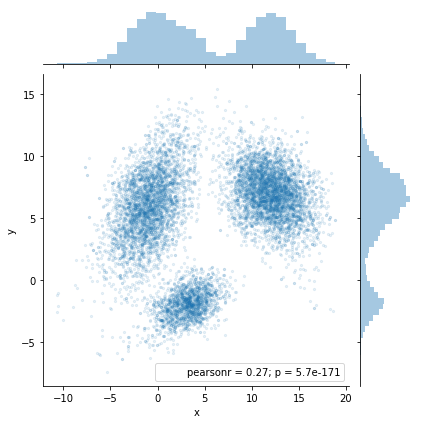

In [409]:
sns.jointplot('x', 'y', pd.DataFrame(samples_pt[2, int(burnin*N)::thin], columns=['x', 'y']), cmap='Blues', alpha=0.1, s=5)
    

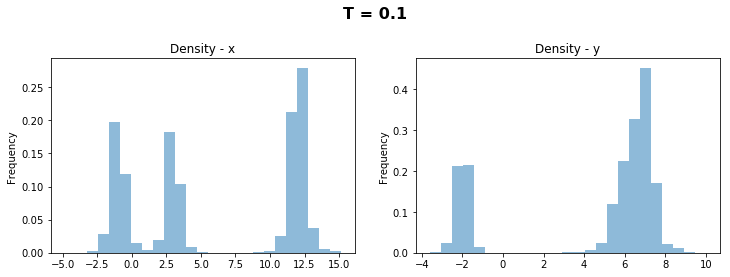

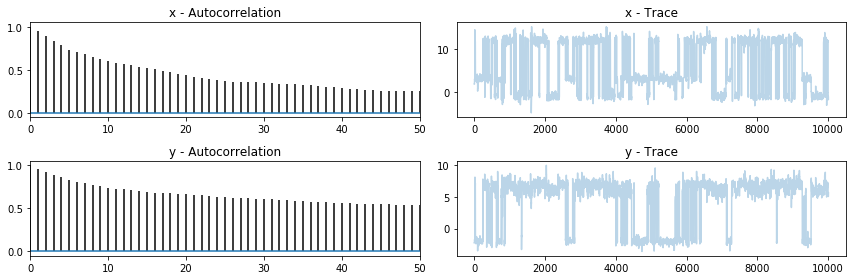

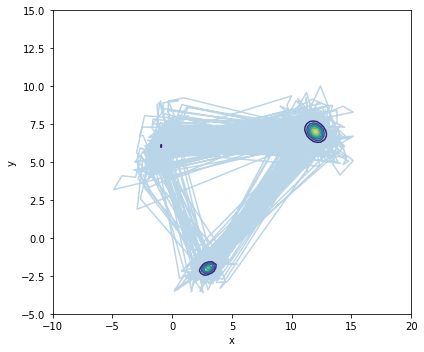

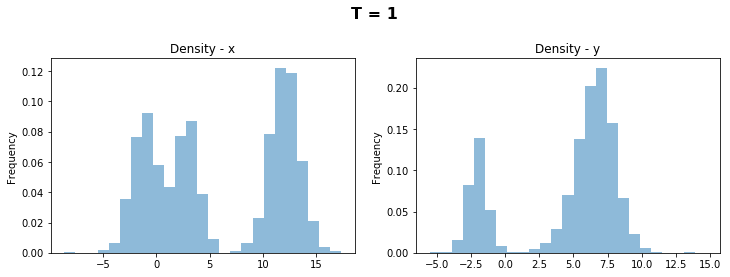

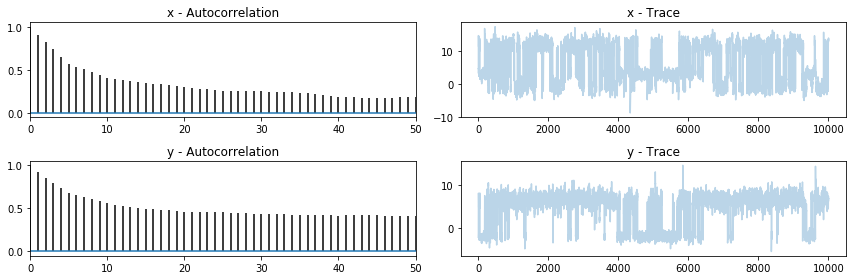

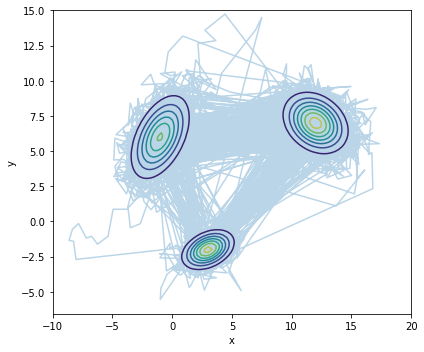

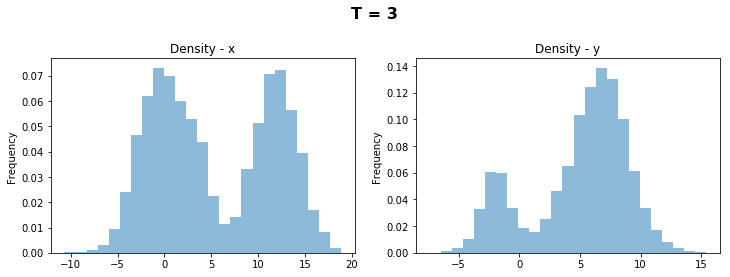

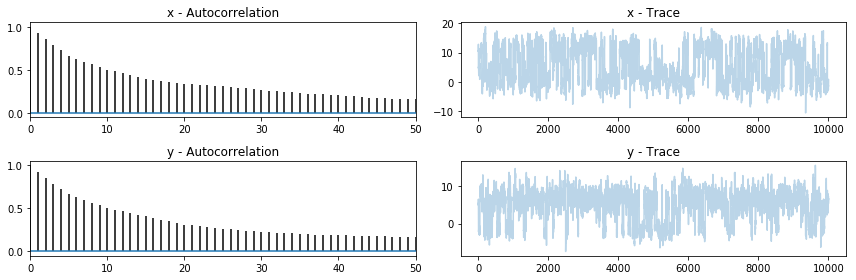

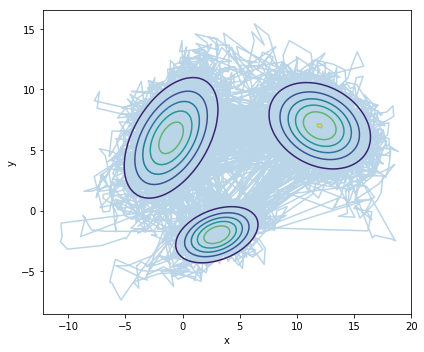

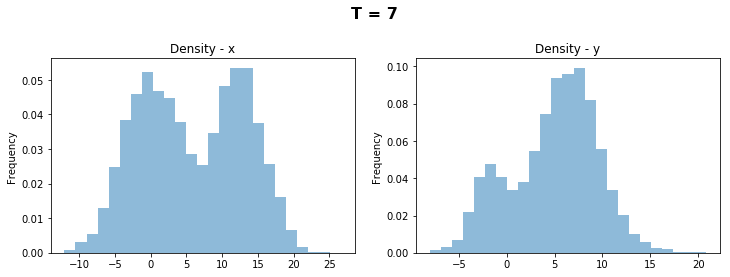

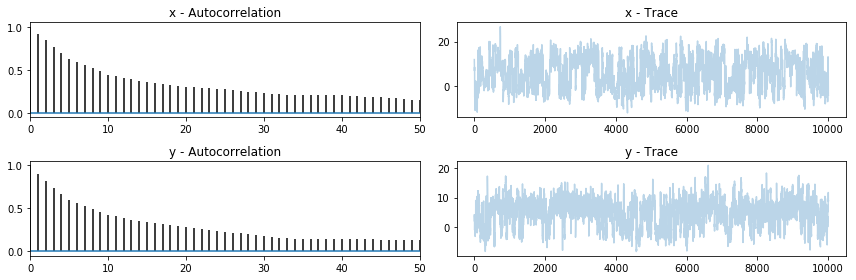

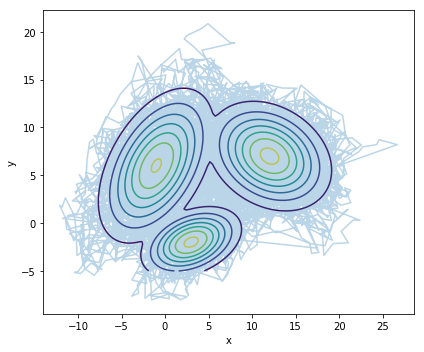

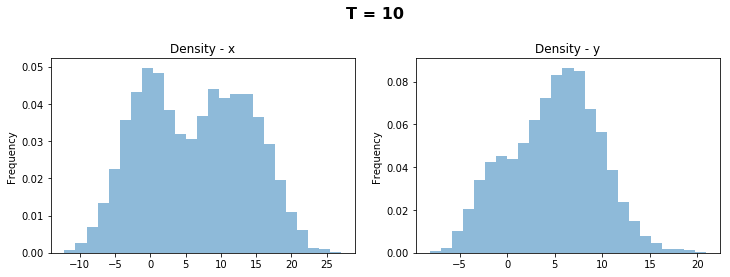

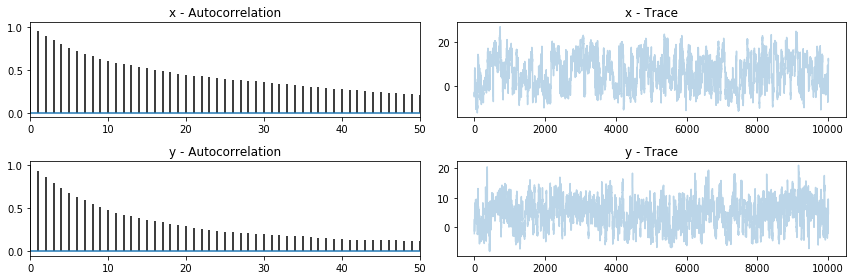

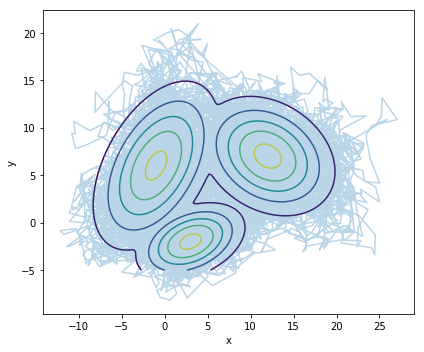

In [410]:
for idx, T in enumerate(T_ls):
    # plotting title
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    plt.suptitle('T = {}'.format(T), fontsize=16, weight='heavy')
    plt.subplots_adjust(top=0.8)
    
    # x, y marginal densities
    pd.Series(samples_pt[idx, int(burnin*N)::thin, 0]).plot(kind='hist', normed=True, alpha=0.5, bins=25, ax=ax[0], title='Density - x')
    pd.Series(samples_pt[idx, int(burnin*N)::thin, 1]).plot(kind='hist', normed=True, alpha=0.5, bins=25, ax=ax[1], title='Density - y')
    
    # autocorrelation & trace plots
    plot_autocorr_trace(samples_pt[idx, int(burnin*N)::thin], ['x', 'y'])
    
    # path plot
    plt.subplots(figsize=(6, 5));
    z = np.empty([100, 100])
    for i, y in enumerate(y_lin):
        for j, x in enumerate(x_lin):
            z[i, j] = p(x, y, T)
            
    plt.contour(x_grid, y_grid, z);
    plt.plot(samples_pt[idx, int(burnin*N)::thin, 0], samples_pt[idx, int(burnin*N)::thin, 1], alpha = 0.3)
    plt.xlabel('x')
    plt.ylabel('y')
    
    plt.tight_layout()

## Part D. Global Optima using Simulated Annealing

We have new-found intuition about how to use temperature to improve our sampling. Lets now tackle the inverse idea: what happens if you sample at a lower temperature than 1. Our visualizations from Part B should indicate to us that the distributions become extremely tightly peaked arounnd their maxima.

If we initialized a metropolis-hastings sampler around an optimum at a really low temperature, it would find us a local minimum. But if we had a higher temperature at the beginning, we can use Metropolis-Hastings sampling at high temperatures to travel around the distribution and find all the peaks (valleys).  Then we will slowly cool down the temperature (which will allow us to escape local optima at higher temperatures) and finally focus us into a particular optimum region and allow you to find the optimum. It can be shown that for ceratin *temperture schedules* this method is guaranteed to find us a global minimum in the limit of infinite iterations.

We'll use this methd to find the global minimum of our distribution. The algorithm is as follows. Now we have only one chain, but we very slowly dial down its temperature to below T=1.

1. Initialize $(x, y)_i,T, L(T)$ where $L$ is the number of iterations at a particular temperature. 
2. Perform $L$ transitions thus(we will call this an epoch):
    1. Generate a new proposed position $(x, y)_{\ast}$ using 2 independent gaussians with $\sigma=1$.
    2. If $(x, y)_{\ast}$ is accepted (according to probability $P = e^{(-\Delta E/T)}$, set $(x, y)_{i+1} = (x, y)_{\ast}$, else set $(x, y)_{i+1} = x_{i}$  
3. Update T and L 
4. Until some fixed number of epochs, or until some stop criterion is fulfilled, goto 2.

$\Delta E$ is the change in enery, or the change in the negative log of the probability function. That is, $E = -log p(x,y)$. For a given T and L, this is just Metropolis!

This algorithm is called *simulated annealing* and we'll use it to find the global maximum for $f(X)$

**D1**. Use simulated annealing with a cooling schedule of $T_{k+1}=0.98T_{k}$ and a L(T) defined initially at 100 with $L_{k+1} = 1.2 L_k$ to find the global optima for $p(x, y)$.  Plot $E(x, y)$ vs iterations.  Given how we constructed $p(x, y)$ it should be fairly straight-forward to observe the  true optima by inspection.  How does the optima found by SA compare to the true optima?

In [14]:
## D1
# B2
def energy(x):
    return -np.log(p(x[0], x[1]))

def simulated_annealing(p, m, c, N, start, epochs, L = 5, T = 20, burnin=0.1, thin=2):
    samples = []
    x_prev = start

    L_sum = 0
    E = []
    E_best = energy(x_prev)
    
    
    for epoch in range(epochs):
        rvs = multivariate_normal.rvs(m, c, size = L)
        for i in range(L):
            x_star = x_prev + rvs[i]
            
#             p_star = p(x_star[0], x_star[1], T)
#             p_prev = p(x_prev[0], x_prev[1], T)
#             pdf_ratio = p_star / p_prev
            
            E_star = energy(x_star)
            E_prev = energy(x_prev)
            
            if ((E_star < E_prev) or (np.random.uniform() < min(1, np.exp((E_prev - E_star)/T)))):
                x_prev = x_star
                if E_star < E_best:
                    E_best = E_star
                    T_best = T
                    x_best = x_star
            
#             if (L_sum + i) % thin == 0:
#                 E.append(energy(x_prev))
            E.append(energy(x_prev))
            samples.append(x_prev)
    
            if E[-1] < energy([3, -2]) - 1e-8:
                break
                
            
        L_sum += L
        L = int(np.ceil(1.2 * L))
        T = 0.98 * T
        
        if epoch % 5 == 0:
            print('epoch = {}'.format(epoch), end='\r')
        
    # throw away burnin and thin
    #samples = samples[int(burnin*N)::thin]

    best_meta = {}
    best_meta['T'] = T_best
    best_meta['E'] = E_best
    best_meta['x'] = x_best
    
    return samples, E, best_meta

In [15]:
# def simulated_annealing(p, q_draw, m, c, N, start, epochs, L = 5, T = 20, burnin=0.1, thin=2):
#     samples = np.empty((N, 2))
#     x_prev = start
#     accepted = np.zeros((N,))
#     L_sum = 0
#     for epoch in range(epochs):
#         for i in range(L):
#             x_star = q_draw(x_prev, m, c)
#             p_star = p(x_star[0], x_star[1], T)
#             p_prev = p(x_prev[0], x_prev[1], T)
#             pdf_ratio = p_star / p_prev
#             if np.random.uniform() < min(1, pdf_ratio):
#                 samples[L_sum + i, :] = x_star
#                 x_prev = x_star
#                 accepted[L_sum + i] = 1
#             else:
#                 samples[L_sum + i, :] = x_prev
        
#         L_sum += L
#         L = int(np.ceil(1.2 * L))
#         T = 0.98 * T
        
#         if epoch % 10 == 0:
#             print('epoch = {}'.format(epoch), end='\r')
            
#     # throw away burnin and thin
#     samples = samples[int(burnin*N)::thin]
#     accepted_count = np.sum(accepted[int(burnin*N)::thin])
            
#     return samples, accepted_count/len(samples)

In [16]:
L = 100
epochs = 45

N = 0
L_tmp = L
for epoch in range(epochs):
    N += L_tmp
    L_tmp = int(np.ceil((1.2 * L_tmp)))

N

1845071

In [19]:
samples_sa, E_sa, best_meta = simulated_annealing(p, m, c, N, [10, -10], epochs, L, T = 3)

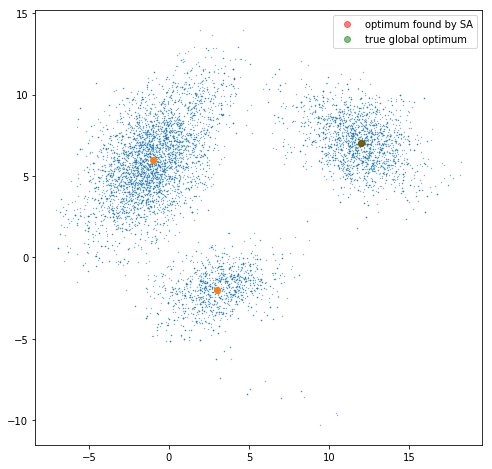

In [21]:
plt.subplots(figsize=(8, 8));
plt.scatter([x[0] for x in samples_sa], [x[1] for x in samples_sa], s= 0.1, alpha= 0.8);
plt.scatter([x[0] for x in [mu1, mu2, mu3]], [x[1] for x in [mu1, mu2, mu3]]);
plt.scatter(best_meta['x'][0],best_meta['x'][1], color = 'red', label = 'optimum found by SA', alpha = 0.5)
plt.scatter(mu1[0], mu1[1], color = 'green',alpha = 0.5, label = 'true global optimum');
plt.legend();

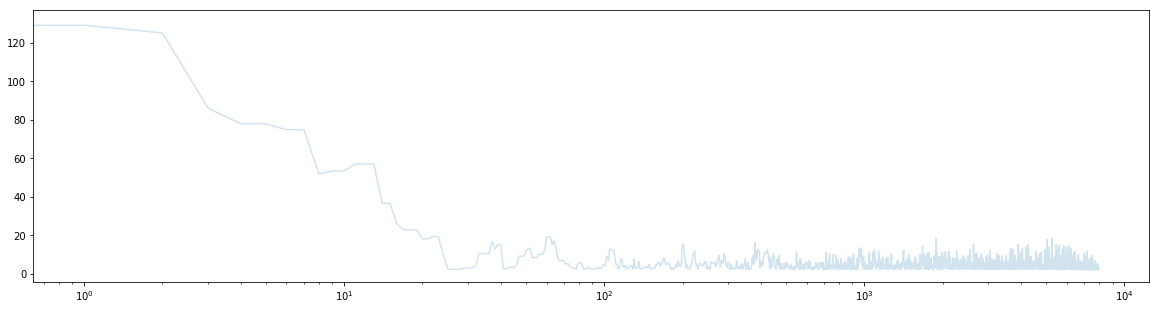

In [22]:
plt.subplots(figsize=(20, 5));
plt.plot(np.arange(len(E_sa)), E_sa, alpha = 0.2);
plt.xscale('log')

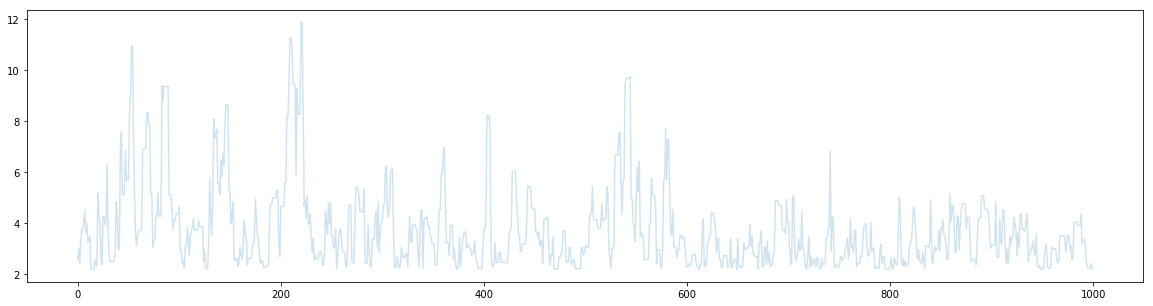

In [23]:
plt.subplots(figsize=(20, 5));
plt.plot(np.arange(len(E_sa[-1000:])), E_sa[-1000:], alpha = 0.2);